# Load libraries and functions and Initialize  

In [2]:
# reload
#%reset
%load_ext autoreload
%autoreload 2 

import warnings
import logging
import os

# DEBUG MODE
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.FATAL)
    
from helper_functions import *

# Sets the random seed
# If you want to set a specific seed then pass it as an argument 
initialize(561)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Run with random seed:  561
GPU is available.
1


# Set string for saving results and code 

In [3]:
#notebook_save_str = 'sup_singleStes_nextWindow_mlp'#'sup_singleStep_nextWindow_mlp' # template 'sup_past5Steps_nextWindow_xgb'
notebook_save_str = 'tmp'

# Set Experiment Parameters

In [4]:
#========================================
# Experiment Parameters: Check carefully!
#========================================

# This is where models are saved and loaded from
#dataset_folder = '../../../dataset_ver1/parsed_data_5steps/' # 500 ms with 5 100ms steps 
dataset_folder = '../../../dataset_ver1/parsed_data4/' # 500 ms single steps
models_folder = 'models/dae_pretrain/'
pretrain_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']
train_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all', 'only_delay']
test_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']
EXP_PARAM = {
    'scaler': 'standard', #'minmax', 'standard', 'robust', 'maxabs', 'l2norm'
    'num_rand_runs': 3 # number of runs with each run doing a different random sample of size label_no from the set of labeled samples 
}

num_samples_list = [100, 1*K, 10*K, 20*K] 
#num_samples_list = [20*K]

scaler_to_save_name = EXP_PARAM['scaler']+'_scaler'

#==================================
# Pretraining Experiment Parameters
#==================================

pretrain = True
pretrain_type = 's3l_dae'
pretrain_model_to_save_name = pretrain_slice+'_'+pretrain_type

#==========================================
# Supervised Training Experiment Parameters
#==========================================

# Load an existing pretrained model to use as encoding for sup model 
use_pretrained_model = True
freeze_encoder = False 
pretrain_model_to_load_type = 's3l_dae'
pretrain_model_to_load_name = pretrain_slice+'_'+pretrain_type
scaler_to_load_name = EXP_PARAM['scaler']+'_scaler.pkl'

# Train a sup model with or without using a pretrained model 
sup_model_type = 'mlp' #['mlp', 'xgb', 'tabnet', 'vime']
suptrain_model_to_save_name = train_slice+'_s3l_dae_mlp' # could also be sup_model_with_pretrain 


#==================================================
# Experiment Parameters: Not often changed
#==================================================

time_step_size = '500ms'

# When input features are NA 
# Could experiment with forward fill imputation 
# If the label is NA during supervised training then the sample is dropped  
impute_method = 'forward_fill'# ['forward_fill', 'zero_fill']
                              
# These are the ones we have chosen to work with  
#learning_tasks = ['httpClientRtt_trace.txt_page_load_time']
learning_tasks = [#'dashClient_trace.txt_newBitRate_bps', 
                  'vrFragment_trace.txt_vr_frag_thput_mbps', 'vrFragment_trace.txt_vr_burst_thput_mbps',
                  'vrFragment_trace.txt_vr_frag_time', 'vrFragment_trace.txt_vr_burst_time', 
                  #'httpClientRtt_trace.txt_page_load_time',
                  'delay_trace.txt_ul_delay', 'delay_trace.txt_dl_delay']
# index matched with the learning_tasks above
#learning_task_types = ['reg']
learning_task_types = [#'clas', 
                       'reg', 'reg', 
                       'reg', 'reg',
                       #'reg',
                       'reg', 'reg']

# If True then we are predicting one window ahead if False then we are predicting on the same window 
shift_samp_for_predict = True

# If you want the test samples to be sorted by delay value to see the error differences for the low delay and high delay cases 
sort_test_samples = False

use_all_feats = True
# take the top n features of each run and add it to the top_n_features list  
# If use_all_feats = True then thes will not be used 
feat_filter = 10 
top_n_features = []
# Only valid when use_all_feats = False 
selected_features = []

# All delay values above this will be clipped to the threshold value
clip_outliers = True
delay_clip_th = 5000 # ms

# Set Model Hyperparameters

In [5]:
# Hyperparameters for SSL using DAE 

s3l_hyp_ssl_dae={
    'metric': "mean_absolute_percentage_error",
    'hidden_dim': 512,
    'encoder_depth': 4,
    'head_depth': 2,
    'noise_type': "Swap",
    'noise_ratio': 0.3,
    'max_epochs': 2,
    'batch_size': 128
}

s3l_sup_mlp={
    'batch_size': 32,
    'max_epochs': 10,
    'loss':{'reg':'MSELoss',
            'clas':'CrossEntropyLoss'},
    'metrics':{'reg':['MeanAbsolutePercentageError'],
               'clas':['Recall']},#'F1Score' does not work needs a different dimension 
}

# Hyperparameters for SSL using TabNet
hypp_ssl_tabnet={
    #'lambda_sparse': , # default = 1e-3
    # This is the extra sparsity loss coefficient as proposed in the original paper. 
    # The bigger this coefficient is, the sparser your model will be in terms of feature selection. 
    # Depending on the difficulty of your problem, reducing this value could help.
    'mask_type': 'entmax', # 'entmax' # default='sparsemax'
    'n_da': 8, # between 8-64 # default=8
    'n_steps': 3, # between 3-10 # default=3
    'n_independent': 2, # between 1-5 # default=2
    'n_shared': 2, # between 1-5 # default=2
    'n_shared_decoder': 1, # default=1
    'n_indep_decoder': 1, # default=1
    'noise_ratio': 0.30,
    'batch_size': 1024, #default=1024
    'max_epochs': 200, # default=200
    'patience': 15 # default=10
}

# Hyperparameters for supervised XGB training 
hypp_sup_xgb={
    'loss':{'reg':'mse',
            'clas':'categorical_crossentropy'}
} 
# Hyperparameters for supervised MLP training
hypp_sup_mlp={
    'fc_layers': [500, 100], # the hidden layers
    'batch_size': 64,  
    'max_epochs': 500,
    'patience': 15,
    'learning_rate': 0.0001,
    'loss':{'reg':'mse',#'mean_absolute_error' 'mean_absolute_percentage_error'
            'clas':'categorical_crossentropy'},
    'metrics':{'reg':['MeanAbsolutePercentageError'],
               'clas':['Recall']},#'F1Score' does nto work needs a different dimension 
    'out_activation':{'reg':'linear', 
                      'clas':'softmax'} 
} 

# Hyperparameters for supervised TabNet training
hypp_sup_tabnet={
    #'lambda_sparse': , # default = 1e-3
    # This is the extra sparsity loss coefficient as proposed in the original paper. The bigger this coefficient is, the sparser your model will be in terms of feature selection. Depending on the difficulty of your problem, reducing this value could help.
    'mask_type': 'sparsemax', # 'entmax' # default='sparsemax'
    'n_da': 8, # between 8-64 # default=8
    'n_steps': 3, # between 3-10 # default=3
    'n_independent': 2, # between 1-5 # default=2
    'n_shared': 2, # between 1-5 # default=2 
    'batch_size': 1024, #default=1024
    'max_epochs': 200, # default=200
    'patience': 15 # default=10
} 

if sup_model_type == 'tabnet':
    sup_hyper_params=hypp_sup_tabnet
elif sup_model_type == 'mlp':
    sup_hyper_params=hypp_sup_mlp
elif sup_model_type == 'xgb':
    sup_hyper_params=hypp_sup_xgb    


#pretrain_runs = range(1, 10 + 1)
#train_runs = range(11, 17 + 1)
#test_runs = range(18, 20 + 1)

num_pretrain_runs = 10 # 10
num_train_runs = 2 # 7 
num_test_runs = 1 # 3
#train_test_run_nums = np.array(range(11, 20+1))
train_test_run_nums = np.array(range(11, 13+1))


#pretrain_runs = range(1, 10 + 1)
pretrain_runs = range(1, 2 + 1)


# Create the models_folder if it does not already exist
if not os.path.isdir(models_folder):
    os.makedirs(models_folder)

# Load pretraining runs

In [6]:
pretrain_data = read_and_concatenate_runs(pretrain_runs, dataset_folder, pretrain_slice, network_info, time_step_size, 
                                          use_all_feats, drop_col_substr, learning_tasks, shift_samp_for_predict, 
                                          impute_method, sum_cols_substr, all_learning_tasks_in_data)

Concatenating runs:  range(1, 3)
Time to read csv file for run:  2.9783196449279785
Loaded run 1
Time to read csv file for run:  2.9288041591644287
Loaded run 2


# Pretrain using TabularS3L

In [7]:
# First phase

if pretrain:
    # Remove the labels of all prediction tasks which are also in the datset 
    X_pretrain = pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    X_pretrain = X_pretrain.dropna()
    X_cols = X_pretrain.columns
    continuous_cols, categorical_cols = get_cont_and_cat_cols(X_pretrain)
    print(X_pretrain.shape)
    # Create, save and use scaler
    val_scaler = create_scaler(X_pretrain, EXP_PARAM['scaler'])
    with open(models_folder + scaler_to_save_name +'.pkl', 'wb') as f:
        pickle.dump(val_scaler, f)
    
    # transform returns a numpy even when you pass a pandas dataframe 
    X_pretrain = val_scaler.transform(X_pretrain).copy()
    #if pretrain_type == 'dae':
    X_pretrain = pd.DataFrame(X_pretrain, columns=X_cols)
    pretrain_model, trainer = s3l_pretrain_with_dae(X_pretrain, continuous_cols, categorical_cols, s3l_hyp_ssl_dae, 
                                                    models_folder+pretrain_model_to_save_name)
    # save this pretrained model for later use
    trainer.save_checkpoint(models_folder+pretrain_model_to_save_name+'.ckpt')

(359540, 108)


Seed set to 42


(324484, 108)
(17977, 108)
(17079, 108)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2676/2676 [00:39<00:00, 67.71it/s, v_num=7, train_loss=-76.2, val_loss=-113.]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2676/2676 [00:39<00:00, 67.64it/s, v_num=7, train_loss=-76.2, val_loss=-113.]


# Pretrain a new model

In [26]:
if pretrain:
    # Separate the X and the ys from the data
    # remove the labels of all prediction tasks which are also in the datset 
    X_pretrain = pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    print(X_pretrain.shape)
  
    val_scaler = create_scaler(X_pretrain, EXP_PARAM['scaler'])
    # Save the scaler for later use when doing supervised training 
    with open(models_folder + scaler_to_save_name +'.pkl', 'wb') as f:
        pickle.dump(val_scaler, f)

    # Use the scaler to scale
    X_pretrain = val_scaler.transform(X_pretrain).copy()
    
    if pretrain_type == 'dae':
        pretrain_model = pretrain_with_dae(pd.DataFrame(X_pretrain))
        # save this pretrained model for later use 
        pretrain_model.save(models_folder+pretrain_model_to_save_name)
    elif pretrain_type == 'tabnet':
        X_pretrain, X_pretrain_val = train_test_split(X_pretrain, test_size=0.2, shuffle=True) 
        pretrain_model = pretrain_with_tabnet(pd.DataFrame(X_pretrain),  pd.DataFrame(X_pretrain_val))
        pretrain_model.save_model(models_folder+pretrain_model_to_save_name)
        # show the results of feature importance
        tabnet_explain(pretrain_model, X_pretrain_val)
    elif pretrain_type == 'vime':
        # Train VIME-Self
        vime_self_parameters = dict()
        vime_self_parameters['batch_size'] = hyp_ssl_semi_vime['batch_size']
        vime_self_parameters['epochs'] = hyp_ssl_semi_vime['epochs'] 
        vime_self_encoder = vime_self(X_pretrain, hyp_ssl_semi_vime['p_m'], hyp_ssl_semi_vime['alpha'], vime_self_parameters)  
        # Save encoder
        vime_self_encoder.save(models_folder+pretrain_model_to_save_name+'.h5')

# Load Tabnet pretrained model for explainability results

In [22]:
# Load a pretrained model for getting explainability results
# Load the pretrained model and scaler 
#with open(models_folder + scaler_to_load_name + '.pkl', 'rb') as f:
#    val_scaler = pickle.load(f)
#
#
## remove the labels of all prediction tasks which are also in the datset 
#X_pretrain_val = test_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
#print(X_pretrain_val.shape)
#
## Fill with 0 the values that are missing in the input features so that the sample can still be used
#X_pretrain_val = impute_data(X_pretrain_val, impute_method, sum_cols_substr)
#
#X_pretrain_val = val_scaler.transform(X_pretrain_val).copy()
# 
#if pretrain_model_to_load_type == 'tabnet':
#    pretrain_model = TabNetPretrainer()
#    pretrain_model.load_model(models_folder+pretrain_model_to_load_name)
#    X_pretrain_val = pretrain_model.predict(X_pretrain_val)[0]
#    tabnet_explain(pretrain_model, X_pretrain_val)
#else:
#    print('Do not have explainability functionality for this model type')

# Iterate over num. labeled samples
# Iterate over different random initializations  
# Iterate over learning_tasks

# Pre-process data 
# Train model
# Evaluate model


NUM. LABELLED SAMPLES:  100
Random iteration:  0
# train runs used  2
# test runs used  1
Concatenating runs:  [13 11]
Time to read csv file for run:  2.972989082336426
Loaded run 13
Time to read csv file for run:  2.9238545894622803
Loaded run 11
Concatenating runs:  [12]
Time to read csv file for run:  2.966275691986084
Loaded run 12
Time to read data:  24.63215184211731
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6595, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4718  572  498  500  228]
After removing bins that are not populated enough
[0 1 2 3 4] [4718  572  498  500  228]
(6516, 108)
(6516,)
(6516,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3285, 118)
NOTE: removin

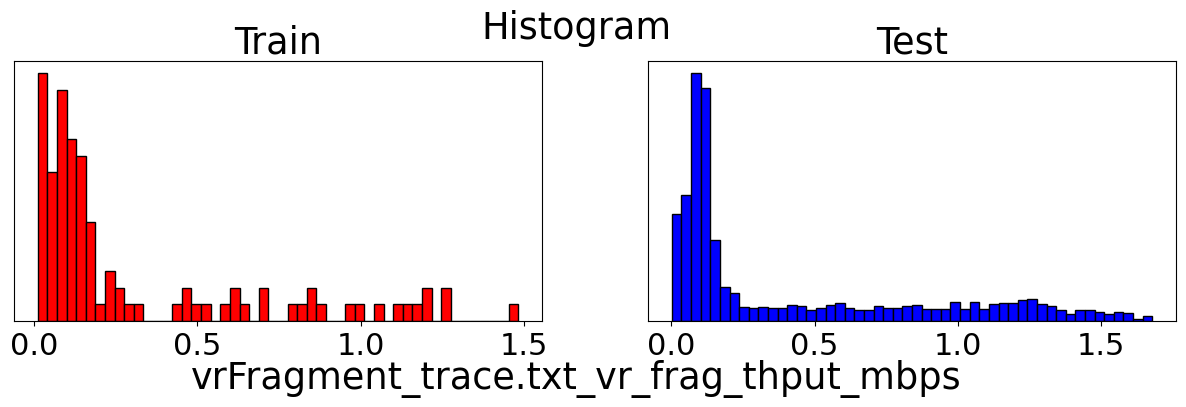

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.4178602695465088
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s, v_num=54, train_loss=0.0962, train_mean_absolute_percentage_error=3.270, val_mean_absolute_percentage_error=3.250, val_loss=0.223]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][0.08596573 0.04444139 0.14552332 0.01270506 1.00217166 0.46180784
 0.03980312 0.2184189  0.8855536  1.04392367 0.23838622 1.19950566
 0.11153514 0.09113842 0.22308044 0.71005182 0.10341803 1.11358323
 0.04604625 0.83206475 0.0231007  0.07847201 0.10038713 0.09281758
 0.01477591 0.08781118 0.83809842 0.03618084 0.01096379 0.08515815
 0.07712662 1.18942947 0.1585514  0.01518709 0.04443739 0.10627796
 0.09720352 0.17174762 0.25338201 0.09172426 0.01614968 0.10334065
 0.10984622 0.15726541 0.10875732 0.09185847 0.05110123 0.15426344
 0.01986925 0.62997649 0.14064763 0.10110162 0.02853537 0.05363769
 0.06628164 0.09318104 0.60274514 0.51977362 0.18554825 0.70307888
 0.1953741  0.15327256 0.07017812 0.13051149 0.1

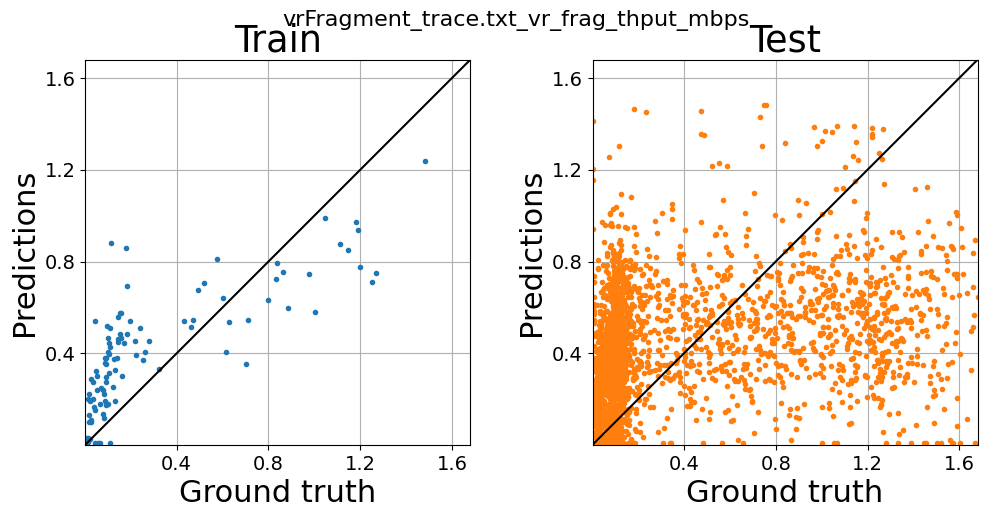



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6592, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4763  546  490  451  264]
After removing bins that are not populated enough
[0 1 2 3 4] [4763  546  490  451  264]
(6514, 108)
(6514,)
(6514,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3281, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2037  253  336  388  234]
After removing bins that are not populated enough
[0 1 2 3 4] [2037  253 

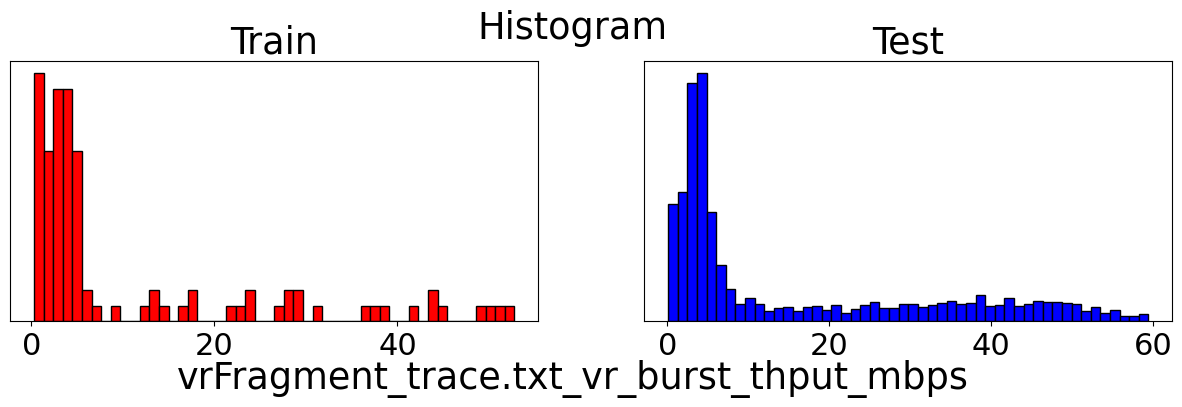

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.353954553604126
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__e

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s, v_num=55, train_loss=140.0, train_mean_absolute_percentage_error=2.120, val_mean_absolute_percentage_error=1.230, val_loss=297.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][24.10291452 13.40649661  0.6390843   4.25033471  4.35324644 29.21830599
 29.6177334   5.2934646   0.34929512 41.35728512 14.50714996  3.43142694
  1.22879228  3.35723001 50.56427561  4.27494499 52.77424651  2.04756166
  3.32347813 37.74543252  1.52768554 44.27359288 13.35769246  3.42224736
  3.81450772 26.66876116  3.20612776  5.35972225  4.61526198  5.14768757
 45.34102912 17.65332896  3.30870225  0.28467138  3.91634312  4.22712602
  3.99914069 50.92049604  6.64332268 22.76153488  4.16737078  3.24362686
  1.252414    3.26797357  1.16076749  2.61239381  3.34245835 16.06474642
  0.55905323  0.71090214  0.65291537 38.37922042  2.88291648  3.32177464
  3.76574125  3.45122063  1.13751698  0.81049567  1.41808996 

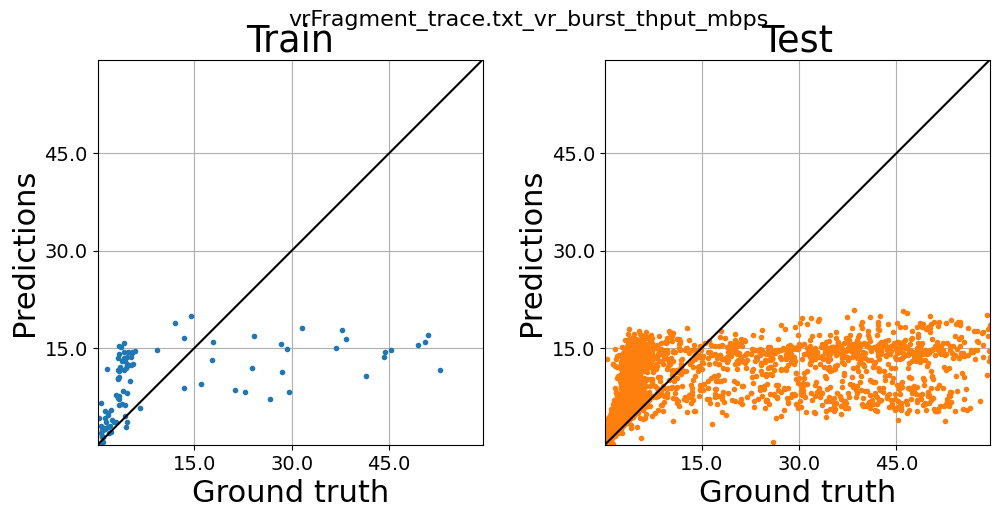



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6595, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5078  833  382  165   58]
After removing bins that are not populated enough
[0 1 2 3 4] [5078  833  382  165   58]
(6458, 108)
(6458,)
(6458,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3285, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2877  251   82   26   16]
After removing bins that are not populated enough
[0 1 2 3 4] [2877  251   82   

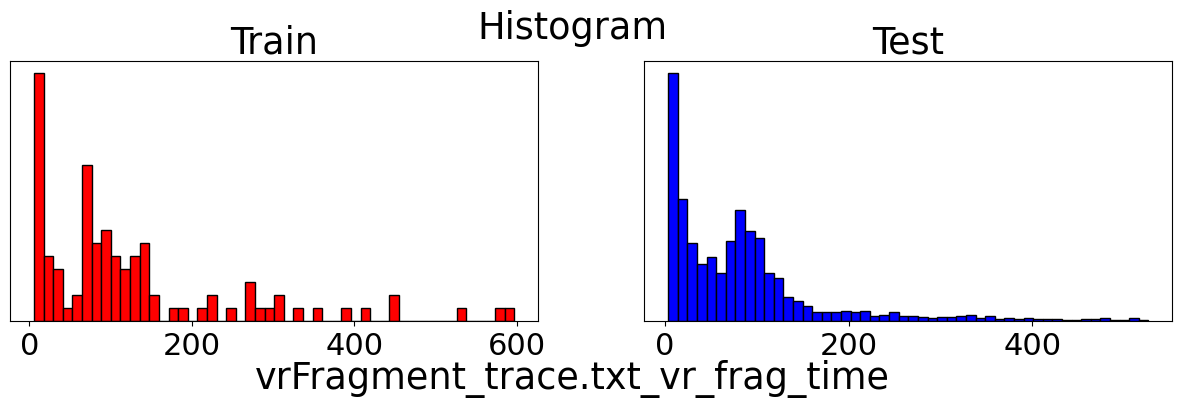

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3440685272216797
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s, v_num=56, train_loss=2.11e+4, train_mean_absolute_percentage_error=0.748, val_mean_absolute_percentage_error=0.815, val_loss=9.68e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][355.13544231 129.47900735   9.61980844  23.33999307  97.04698913
  13.86384492 111.53444957 139.27340074 453.58044444 140.57857034
   9.31693827  70.52074857 105.15368286  13.74062389 116.31217358
 158.40417409  67.6890679   11.05427437  14.00502834  68.6960549
  81.74914679 114.73290712 395.2862     186.41609569 176.20417647
  29.8269418   23.26653846  95.27811111   7.89002731  92.48026566
 307.00423256  97.05705556  10.85794796 131.3506835  128.36831849
 332.1932439   44.93808687 114.57213636  67.00852353 270.1624386
  24.69767319  32.43000881  81.48019775   9.23719856 222.70719136
  57.1807452  250.99891139   5.74356989   9.72953333 409.233725
 103.84612828 268.39797484  85.2060489   67.90418107   9.53203

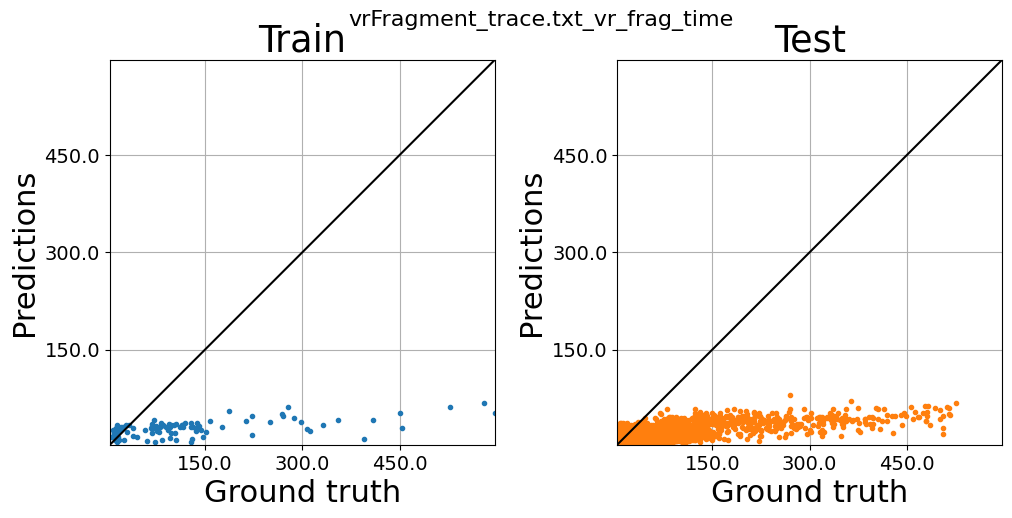



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6592, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5070  844  381  167   52]
After removing bins that are not populated enough
[0 1 2 3 4] [5070  844  381  167   52]
(6462, 108)
(6462,)
(6462,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3281, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2864  249   92   25   18]
After removing bins that are not populated enough
[0 1 2 3 4] [2864  249   92  

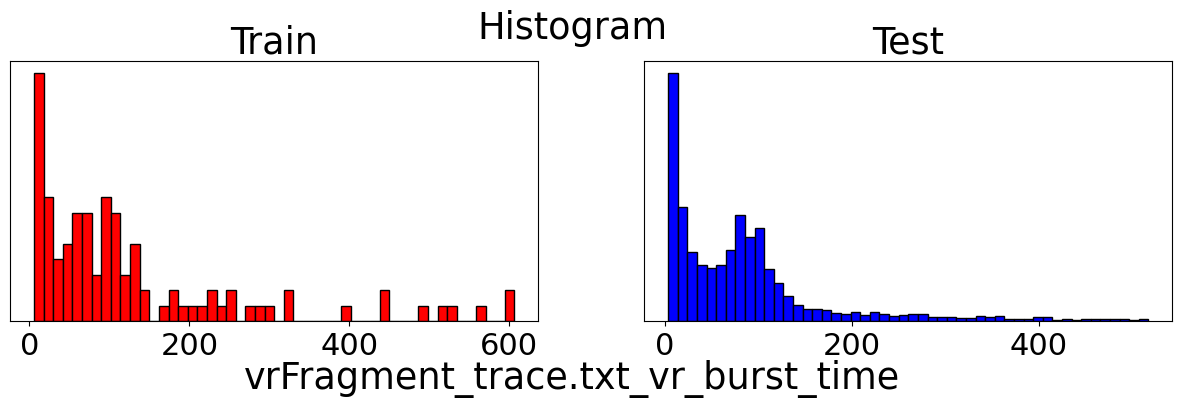

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3573174476623535
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s, v_num=57, train_loss=4.22e+4, train_mean_absolute_percentage_error=0.780, val_mean_absolute_percentage_error=0.812, val_loss=1.02e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 96.97021429   8.5148      28.5736      20.79285714  28.36030769
  18.246       86.82485714 133.51838462 128.8880625  207.86030769
  64.83573333 285.37141176  45.84411765   5.88206667  17.05733333
  12.00185714 110.0263125   12.6609375   58.1315      11.46533333
 168.60128571  13.10946667 222.2309375   50.08057143  15.38226667
 105.5495625   80.53375    106.20633333 104.596625    99.20057143
 512.24376471 606.23123077  48.29935714  77.26725    596.28745455
  51.90035714 178.97773684  38.77152941  34.380625   438.39988235
  75.6985625  321.81929412  15.8588     214.6564     103.5212
 143.07392857 119.734125    21.29707143  67.285875     6.9038
 533.9207619  236.54185714  13.11657143  20.07592857 231.55538889


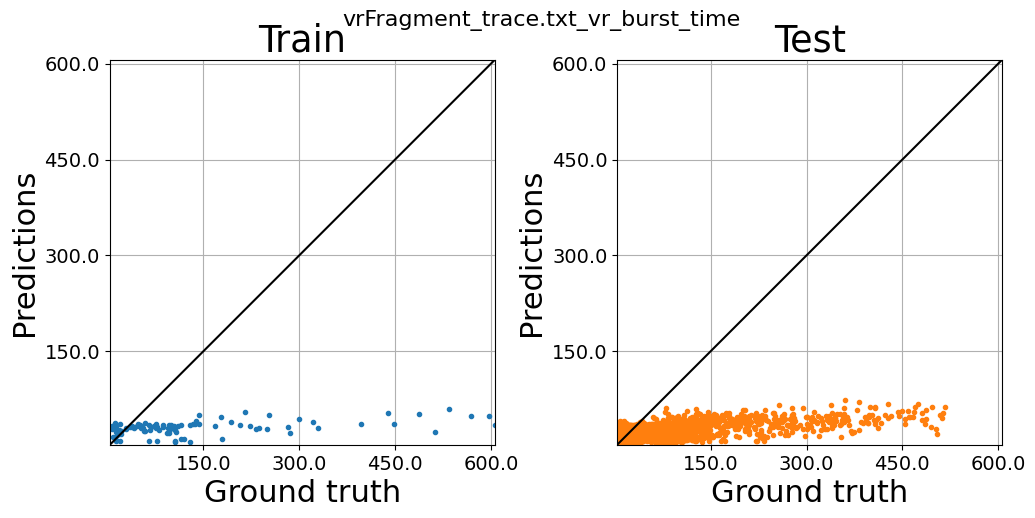



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(340711, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [334344   1389    710    498    362]
After removing bins that are not populated enough
[0 1 2 3 4] [334344   1389    710    498    362]
(334344, 108)
(334344,)
(334344,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(169291, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

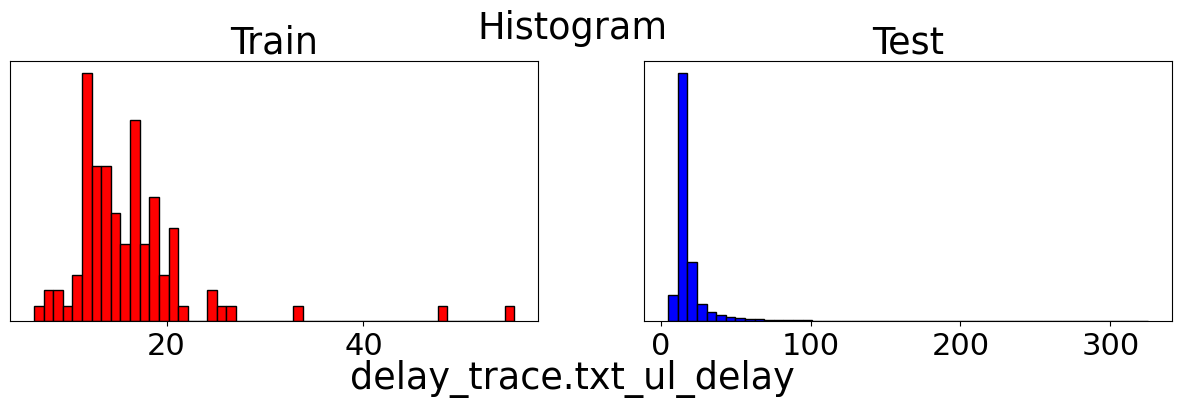

Time to process data for one learning task:  2.477569580078125


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  0.68it/s, v_num=58, train_loss=59.00, train_mean_absolute_percentage_error=0.319, val_mean_absolute_percentage_error=0.285, val_loss=422.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][17.5318     12.265      18.3312     12.334      16.5326     10.933
 11.7314     14.3312     15.931      13.1318     14.7316     14.531
 11.932      14.5314     16.5318     16.7318     12.5316     20.7316
 16.3318     11.932      18.731      12.9312     19.5332     17.5322
 11.9316     11.7318     18.7322     24.93125     6.5312     55.3318
 14.7312      8.3334     12.9324     13.9312     17.731       9.132
 19.5312     15.3312     13.531      13.9322     13.3322     16.931
 14.732      13.1312     16.131      11.9322     16.1324     11.9314
 17.9316     13.3316     17.531      18.9324     14.9314     20.331
  7.7314      8.9312     16.682      21.3314     47.932      24.1312
 14.331      26.43125    14.1312 

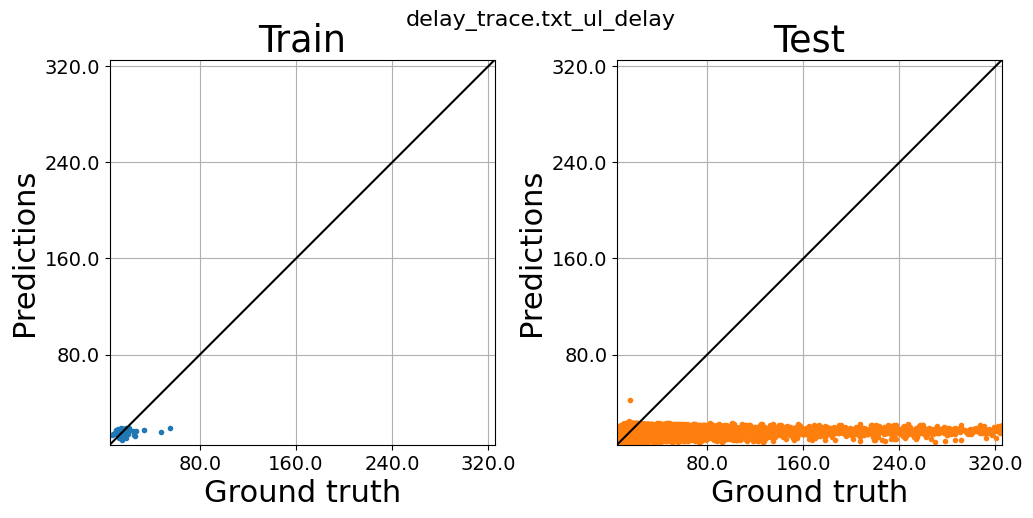



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(359381, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [330219  14596   5926   2970   1709]
After removing bins that are not populated enough
[0 1 2 3 4] [330219  14596   5926   2970   1709]
(350741, 108)
(350741,)
(350741,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(179703, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

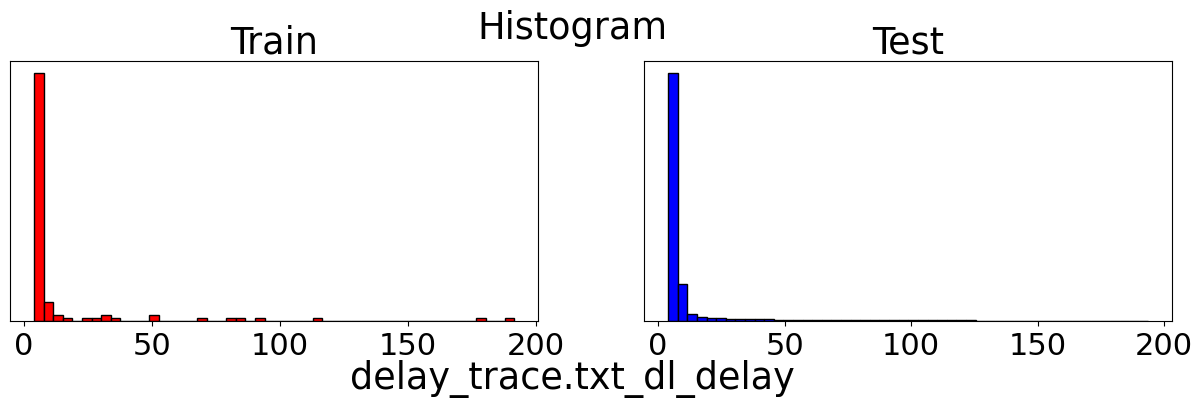

Time to process data for one learning task:  2.644770383834839


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  0.67it/s, v_num=59, train_loss=851.0, train_mean_absolute_percentage_error=1.640, val_mean_absolute_percentage_error=1.570, val_loss=741.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][  3.999        4.999        3.999        3.999       90.999
   5.399        5.399        3.999        4.199        3.999
   3.999        5.399        3.999       10.999        4.599
   4.999        7.999        4.199       52.499        3.999
  23.999        3.999        3.999        3.999        4.399
   3.999        3.999        4.599        5.399        4.999
  36.399        3.999        3.999        9.999        3.999
  68.66566667   3.999        4.199        7.199        3.999
  12.799        5.399      115.399        3.999        3.999
   4.199        4.599        3.999        4.599        3.999
   4.799        3.999       33.33233333   7.799        5.999
 177.999        4.199        3.999        7.399

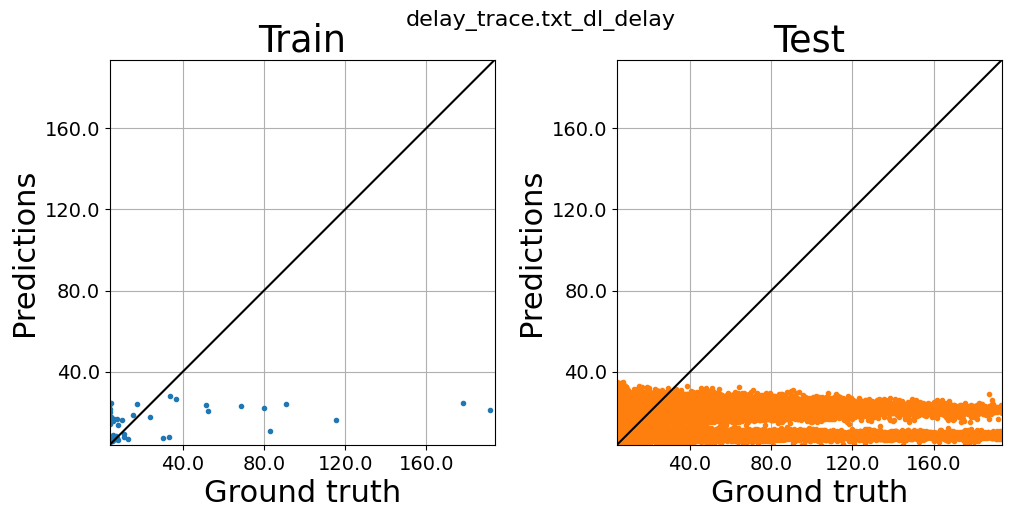



===============================  DONE  ===================================================
Random iteration:  1
# train runs used  2
# test runs used  1
Concatenating runs:  [11 12]
Time to read csv file for run:  2.9201571941375732
Loaded run 11
Time to read csv file for run:  2.9229347705841064
Loaded run 12
Concatenating runs:  [13]
Time to read csv file for run:  2.923638343811035
Loaded run 13
Time to read data:  24.327835083007812
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4109  684  636  719  360]
After removing bins that are not populated enough
[0 1 2 3 4] [4109  684  636  719  360]
(6508, 108)
(6508,)
(6508,)
Dropping rows for which this learning_tasks la

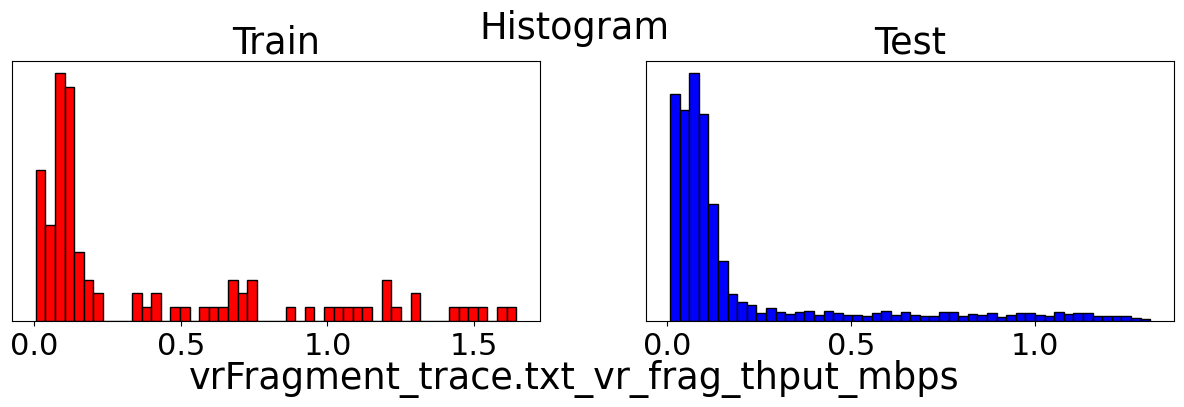

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.35098719596862793
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.51it/s, v_num=60, train_loss=0.224, train_mean_absolute_percentage_error=6.420, val_mean_absolute_percentage_error=4.900, val_loss=0.119]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][0.13327741 0.13844236 1.19304008 0.07778789 0.19331122 0.10342806
 1.51627516 0.0726869  1.29009122 0.02829802 0.11223191 0.16993732
 0.09746303 0.20124898 0.09662214 0.07170803 0.11657427 0.10312934
 0.10732752 0.15075416 0.03180127 0.75172015 1.47040919 0.09494343
 0.06197304 0.56256633 0.06973427 0.66804866 0.16135362 0.87139037
 0.38290209 0.51977362 1.30140595 1.0139395  0.03829362 0.10523272
 0.12982746 1.14881105 0.02902098 0.73050424 1.23219861 1.59376161
 0.08968177 0.09380517 0.11444749 0.10162318 0.41899609 0.13998157
 1.19173102 0.07832111 0.69096078 1.07610378 0.11250972 0.12922048
 0.0929875  0.34466004 0.10291568 1.191597   0.15269867 0.4900449
 0.07310194 0.34166799 1.50500291 0.12722824 0.72

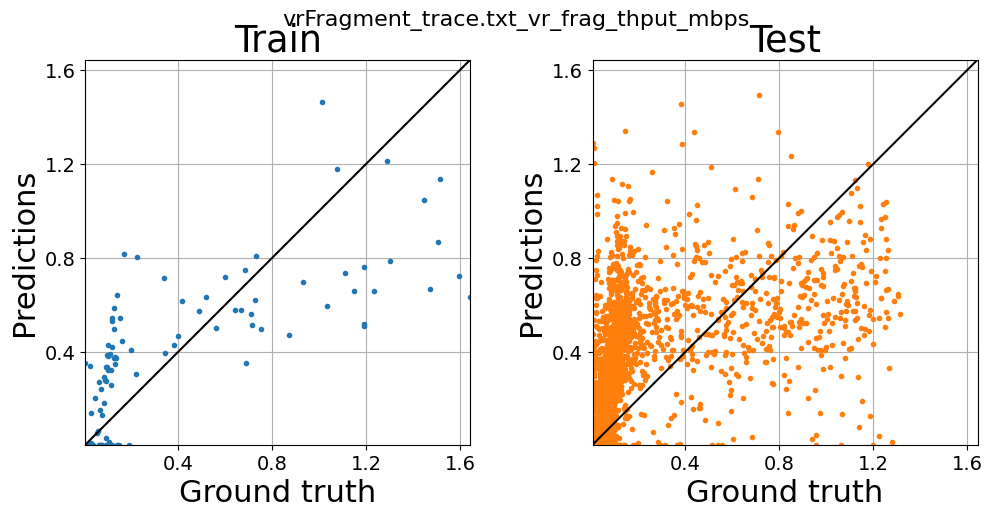



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
After removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
(6503, 108)
(6503,)
(6503,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2664  202  147  148   98]
After removing bins that are not populated enough
[0 1 2 3 4] [2664  202 

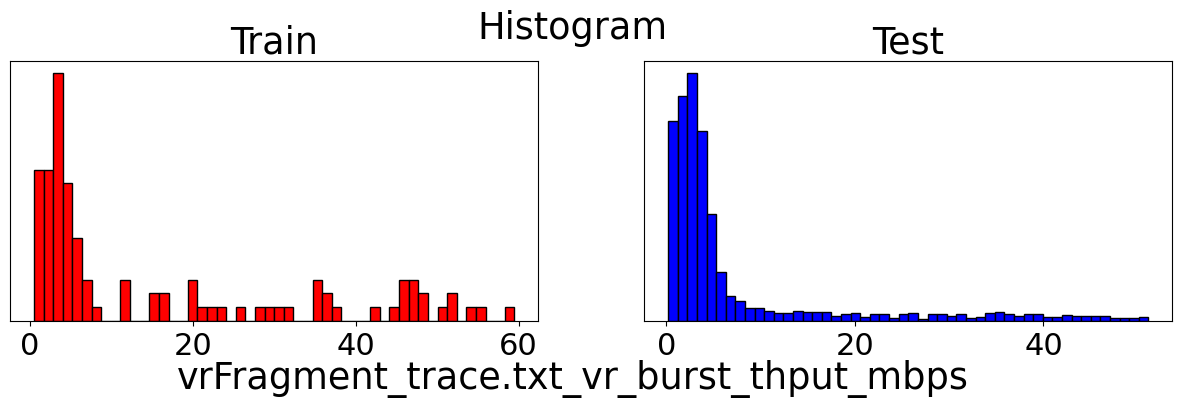

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.36959123611450195
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.53it/s, v_num=61, train_loss=219.0, train_mean_absolute_percentage_error=2.750, val_mean_absolute_percentage_error=5.350, val_loss=154.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 2.51970091 38.1256952   3.37096289  5.38067233 16.47341242 23.90578141
  2.93304996  3.29306621  5.1710465  22.57183357  5.21340778  1.83289452
  3.78123278 45.56657611 25.63774074  0.52413241  1.98809909 36.43249837
 59.49485371 15.07676231 55.89057316  1.3114954  51.92575369  1.81278759
  5.65483904  3.62927281 46.93912078  0.90631956 20.40200509  2.75486431
 12.19136224  6.36704843  3.11558876  3.92316868 30.56845004  7.17151335
 48.12268316  1.38961643 50.53474401  7.33999418 11.65924124 51.48783865
  0.70687724  8.49010673  4.35112223  1.52420121 47.02369148  4.83098889
 20.46012518  1.98997751 48.39981484  5.66802755 45.29316263 35.25419163
  3.91092976 16.02296966  5.34179325 11.4289956   3.65126802 

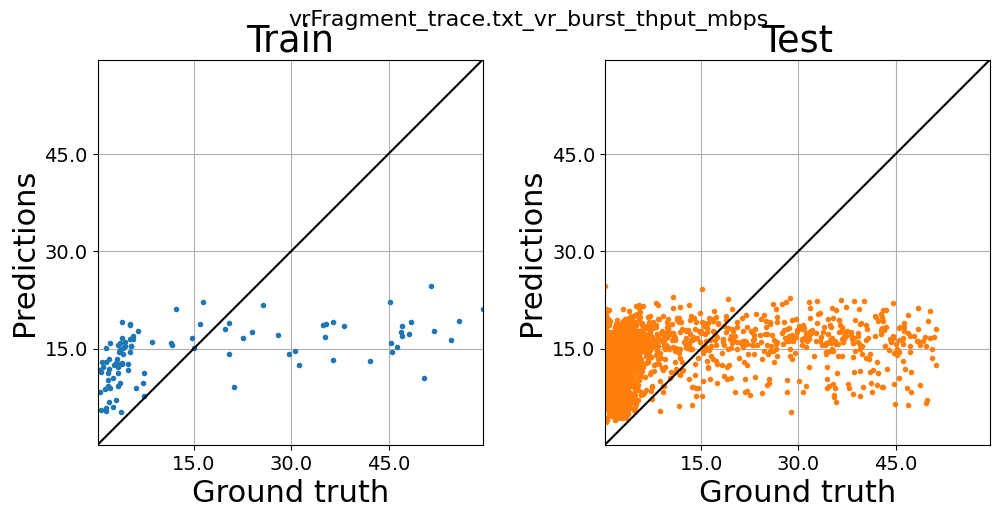



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
After removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
(6453, 108)
(6453,)
(6453,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3293, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   72   42]
After removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   

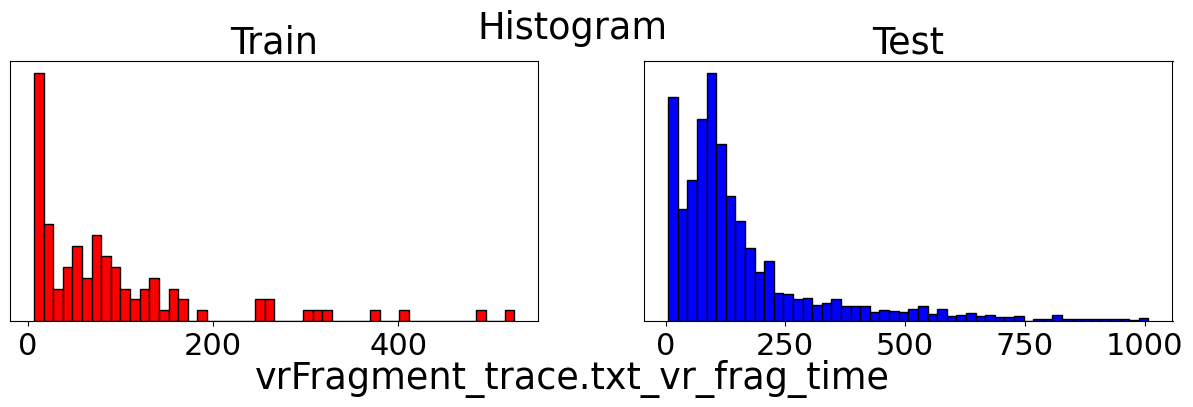

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.372882604598999
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__e

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s, v_num=62, train_loss=1.18e+4, train_mean_absolute_percentage_error=0.741, val_mean_absolute_percentage_error=0.726, val_loss=3.94e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][140.06227473 493.90755556 250.79010204  90.22510363  10.25145951
  21.08195341 252.52193382 113.14310334  30.81560159 130.9011003
 525.53296053  99.53054039  29.43198058 258.47170548 155.02839262
  73.89665226  84.26272082  16.46762058  80.23934474 140.60366791
  23.57561423 379.10267273  19.25625636  94.94880577  11.17935284
 323.5440916  100.51568852  99.62403495  23.6437382   62.49327711
  27.0179042   40.00606934 124.61070533 103.33139058  45.22362197
 311.87050345  25.31282784  38.43942323  16.31008818  54.15401099
  12.29689109 297.63986364  82.30049776  54.61560285  11.62310461
  90.46692537  14.00044923  12.86437205 141.6803777   79.98234459
  77.79280798  73.57405507  67.71134398 133.30910638 157.46

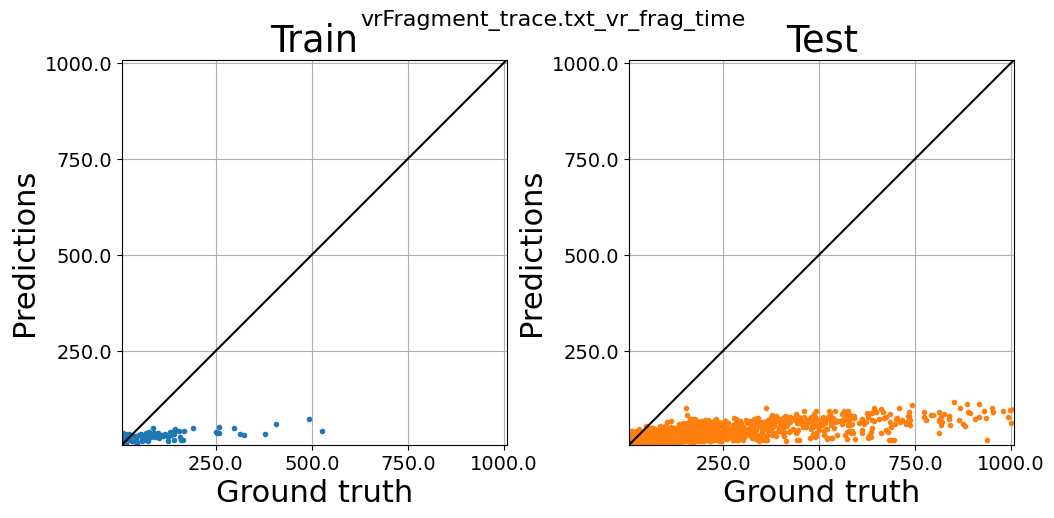



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
After removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
(6444, 108)
(6444,)
(6444,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186   71   38]
After removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186  

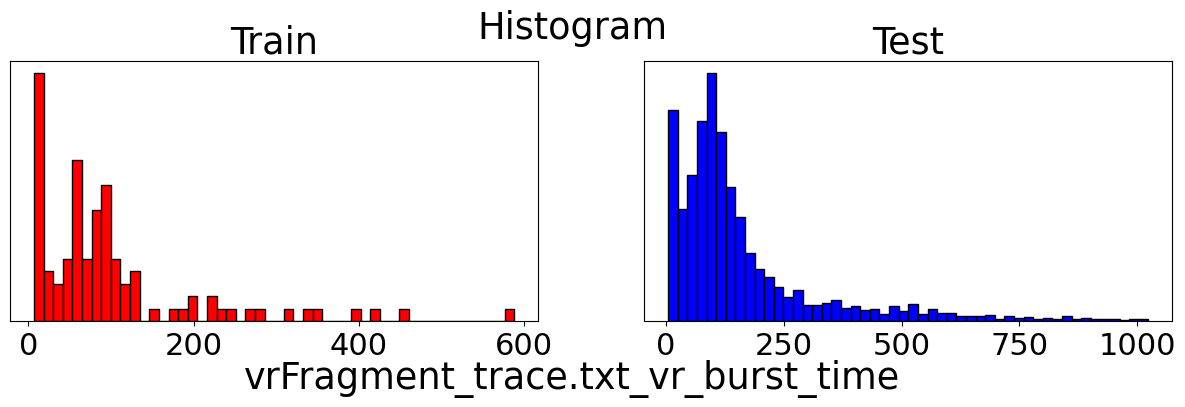

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.36026549339294434
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.50it/s, v_num=63, train_loss=1.5e+4, train_mean_absolute_percentage_error=0.749, val_mean_absolute_percentage_error=0.734, val_loss=4.26e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 87.88293333 132.54046667 121.33473333  11.9815      61.45453333
  94.7         89.874125    97.18307143 221.37746154 106.770125
  83.4545      79.20257143  11.26533333  13.89171429  98.2608125
  99.3316875   88.1585      55.6694     114.27253333  10.51113333
  11.88133333 127.10273333  75.15326667  25.39947059   8.44853333
 147.43575    203.777       55.7334375   77.1168125  101.89513333
 320.431       91.91421429  10.15442857  14.32786667 264.46925
  55.59813333  47.08333333  59.132      130.95573333  93.43273333
   9.90628571  80.39747059  89.25376923 238.58071429  22.23366667
 219.60208333 242.02695455 339.39823077 106.1800625   17.2235
  12.2622     197.39207143  14.47693333  48.56506667  50.294
 423.35

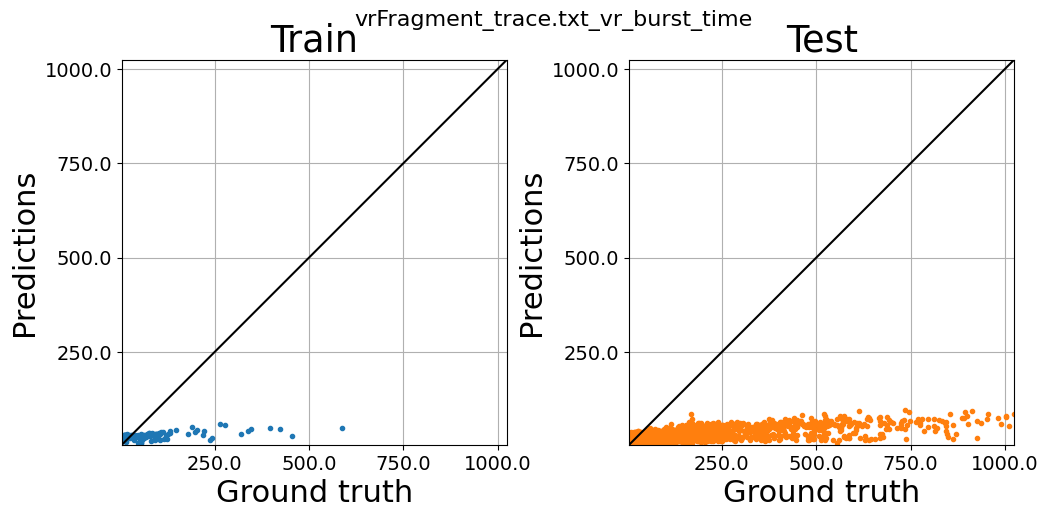



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(342110, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
After removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
(335990, 108)
(335990,)
(335990,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(167892, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

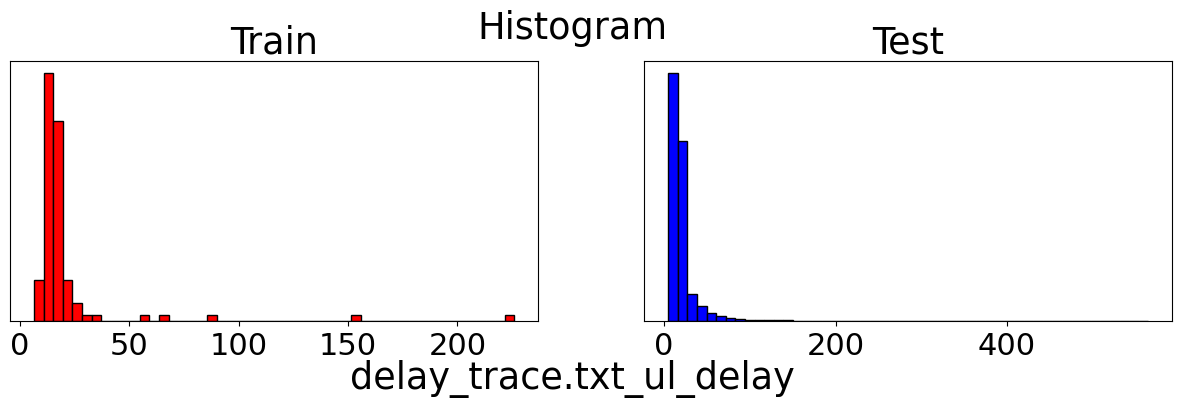

Time to process data for one learning task:  2.5136446952819824


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  0.62it/s, v_num=64, train_loss=570.0, train_mean_absolute_percentage_error=0.452, val_mean_absolute_percentage_error=0.375, val_loss=1.28e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 15.1322      12.731       10.9312      15.7316      11.9324
  17.5322      13.68175     19.1312      12.3314      36.682
  14.7318      12.7314      23.5318      18.9312     152.1334
 226.09866667  17.532       88.9312      13.9316      15.6825
  14.1312      12.531       17.1815      13.5324      19.131
  16.3314      18.131       21.732       18.9314      13.931
  15.93116667  16.5314      18.09916667  18.7318      21.933
  17.5312      18.5312      13.131       64.59833333  10.3316
  32.1322      16.532       12.5322      57.9316      12.131
  12.1316      16.5318      16.3316      11.9312      23.68125
  24.26633333  11.9312      14.1314      16.131       12.7316
  19.43125     10.3322      15.1318     

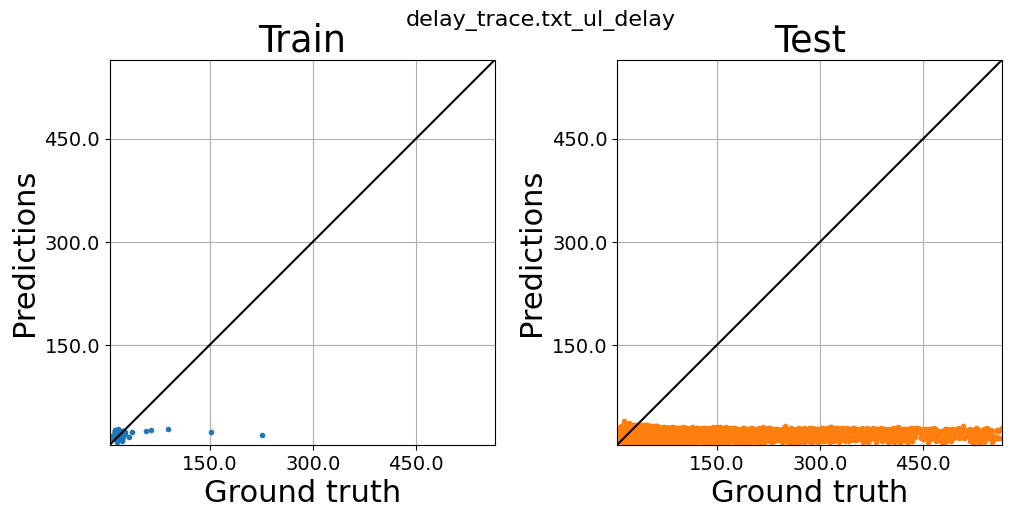



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(359433, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
After removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
(350432, 108)
(350432,)
(350432,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(179651, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

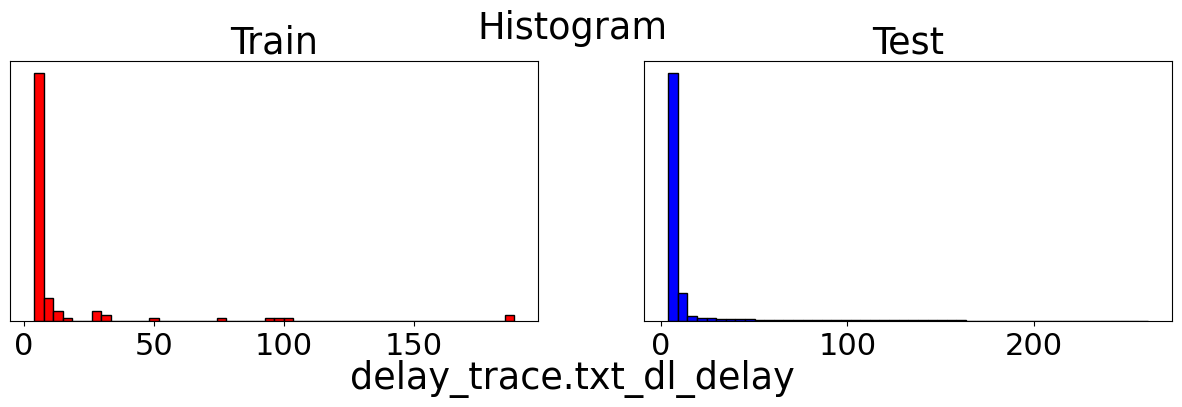

Time to process data for one learning task:  2.585779905319214


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  0.66it/s, v_num=65, train_loss=715.0, train_mean_absolute_percentage_error=1.610, val_mean_absolute_percentage_error=1.270, val_loss=1.37e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 97.199      188.799        4.499        3.999        3.999
   3.999       75.249        3.999        5.399        3.999
   7.199       11.999        3.999        3.999        3.999
 186.499        9.599        3.999        3.999        4.599
   4.999        7.599       12.599        3.999        3.999
   5.599        4.199       49.999        3.999       10.999
   3.999        3.999        3.999        3.999        4.599
   5.999       27.66566667   5.599        7.199        4.199
   4.199        3.999        7.999        4.399        4.799
   3.999        3.999        7.599        7.999       10.999
   3.999        3.999        3.999        3.999       15.199
   4.199        4.999        3.999        3.999

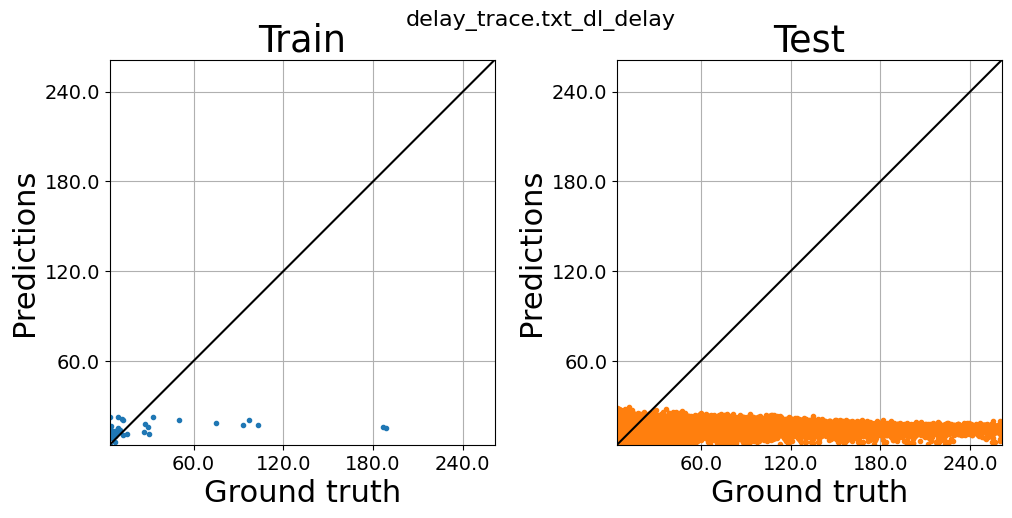



===============================  DONE  ===================================================
Random iteration:  2
# train runs used  2
# test runs used  1
Concatenating runs:  [11 12]
Time to read csv file for run:  2.879703998565674
Loaded run 11
Time to read csv file for run:  2.9047045707702637
Loaded run 12
Concatenating runs:  [13]
Time to read csv file for run:  2.8867993354797363
Loaded run 13
Time to read data:  25.07459306716919
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4109  684  636  719  360]
After removing bins that are not populated enough
[0 1 2 3 4] [4109  684  636  719  360]
(6508, 108)
(6508,)
(6508,)
Dropping rows for which this learning_tasks lab

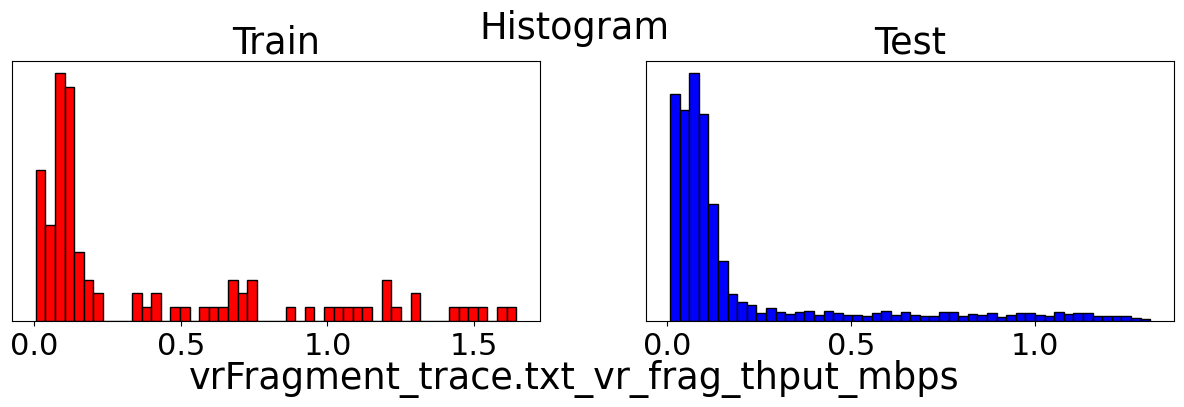

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.36968231201171875
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s, v_num=66, train_loss=0.224, train_mean_absolute_percentage_error=6.420, val_mean_absolute_percentage_error=4.900, val_loss=0.119]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][0.13327741 0.13844236 1.19304008 0.07778789 0.19331122 0.10342806
 1.51627516 0.0726869  1.29009122 0.02829802 0.11223191 0.16993732
 0.09746303 0.20124898 0.09662214 0.07170803 0.11657427 0.10312934
 0.10732752 0.15075416 0.03180127 0.75172015 1.47040919 0.09494343
 0.06197304 0.56256633 0.06973427 0.66804866 0.16135362 0.87139037
 0.38290209 0.51977362 1.30140595 1.0139395  0.03829362 0.10523272
 0.12982746 1.14881105 0.02902098 0.73050424 1.23219861 1.59376161
 0.08968177 0.09380517 0.11444749 0.10162318 0.41899609 0.13998157
 1.19173102 0.07832111 0.69096078 1.07610378 0.11250972 0.12922048
 0.0929875  0.34466004 0.10291568 1.191597   0.15269867 0.4900449
 0.07310194 0.34166799 1.50500291 0.12722824 0.72

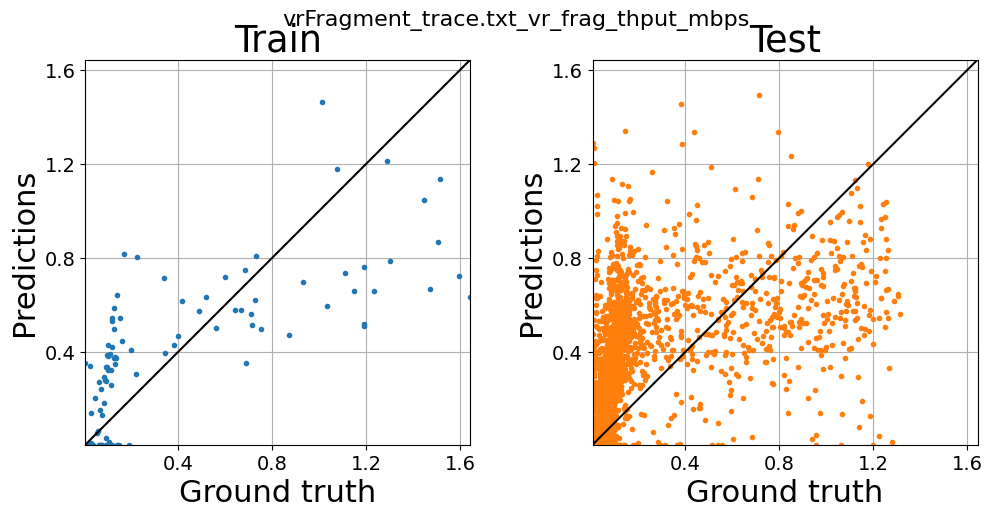



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
After removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
(6503, 108)
(6503,)
(6503,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2664  202  147  148   98]
After removing bins that are not populated enough
[0 1 2 3 4] [2664  202 

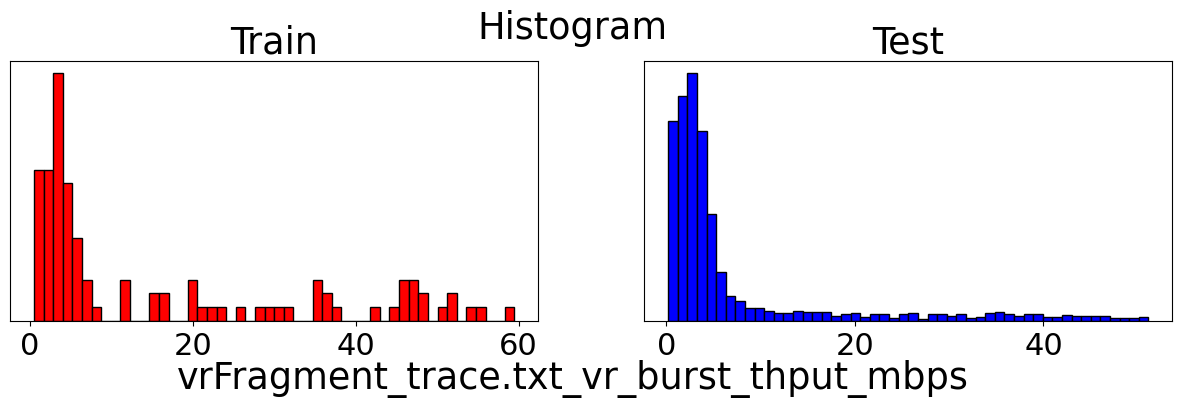

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3707871437072754
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s, v_num=67, train_loss=219.0, train_mean_absolute_percentage_error=2.750, val_mean_absolute_percentage_error=5.350, val_loss=154.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 2.51970091 38.1256952   3.37096289  5.38067233 16.47341242 23.90578141
  2.93304996  3.29306621  5.1710465  22.57183357  5.21340778  1.83289452
  3.78123278 45.56657611 25.63774074  0.52413241  1.98809909 36.43249837
 59.49485371 15.07676231 55.89057316  1.3114954  51.92575369  1.81278759
  5.65483904  3.62927281 46.93912078  0.90631956 20.40200509  2.75486431
 12.19136224  6.36704843  3.11558876  3.92316868 30.56845004  7.17151335
 48.12268316  1.38961643 50.53474401  7.33999418 11.65924124 51.48783865
  0.70687724  8.49010673  4.35112223  1.52420121 47.02369148  4.83098889
 20.46012518  1.98997751 48.39981484  5.66802755 45.29316263 35.25419163
  3.91092976 16.02296966  5.34179325 11.4289956   3.65126802 

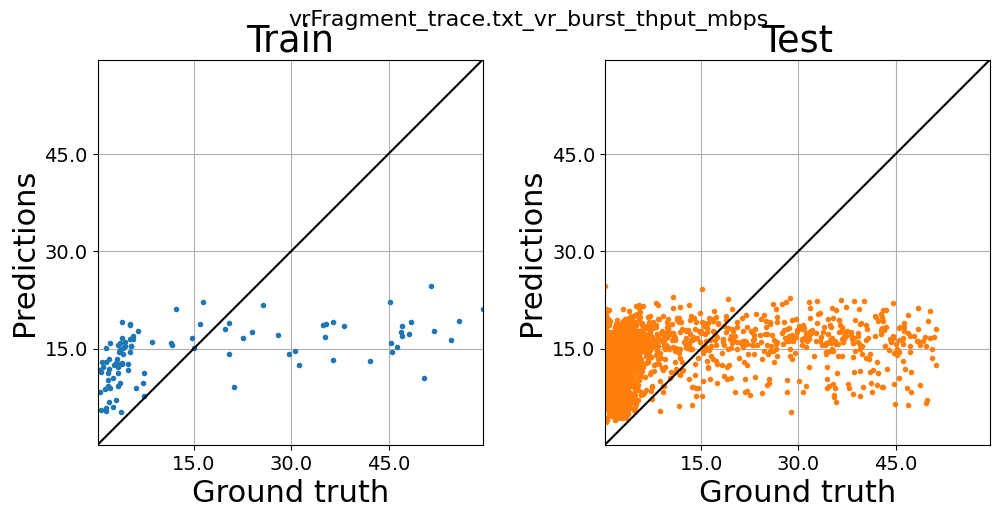



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
After removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
(6453, 108)
(6453,)
(6453,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3293, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   72   42]
After removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   

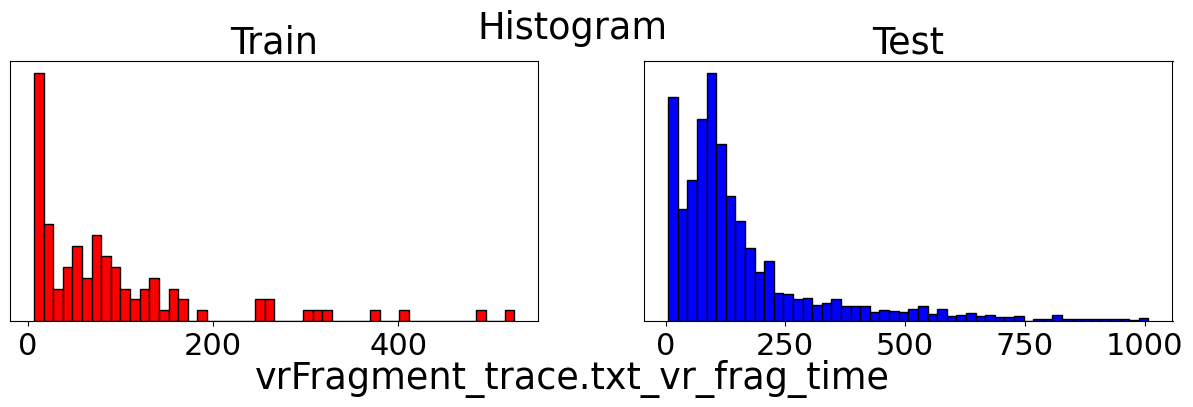

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3600752353668213
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s, v_num=68, train_loss=1.18e+4, train_mean_absolute_percentage_error=0.741, val_mean_absolute_percentage_error=0.726, val_loss=3.94e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][140.06227473 493.90755556 250.79010204  90.22510363  10.25145951
  21.08195341 252.52193382 113.14310334  30.81560159 130.9011003
 525.53296053  99.53054039  29.43198058 258.47170548 155.02839262
  73.89665226  84.26272082  16.46762058  80.23934474 140.60366791
  23.57561423 379.10267273  19.25625636  94.94880577  11.17935284
 323.5440916  100.51568852  99.62403495  23.6437382   62.49327711
  27.0179042   40.00606934 124.61070533 103.33139058  45.22362197
 311.87050345  25.31282784  38.43942323  16.31008818  54.15401099
  12.29689109 297.63986364  82.30049776  54.61560285  11.62310461
  90.46692537  14.00044923  12.86437205 141.6803777   79.98234459
  77.79280798  73.57405507  67.71134398 133.30910638 157.46

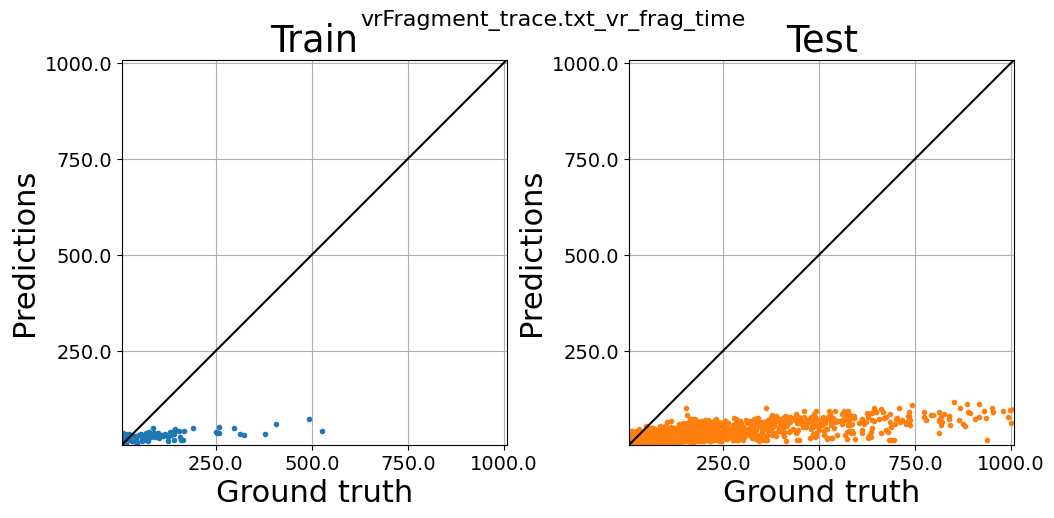



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
After removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
(6444, 108)
(6444,)
(6444,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186   71   38]
After removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186  

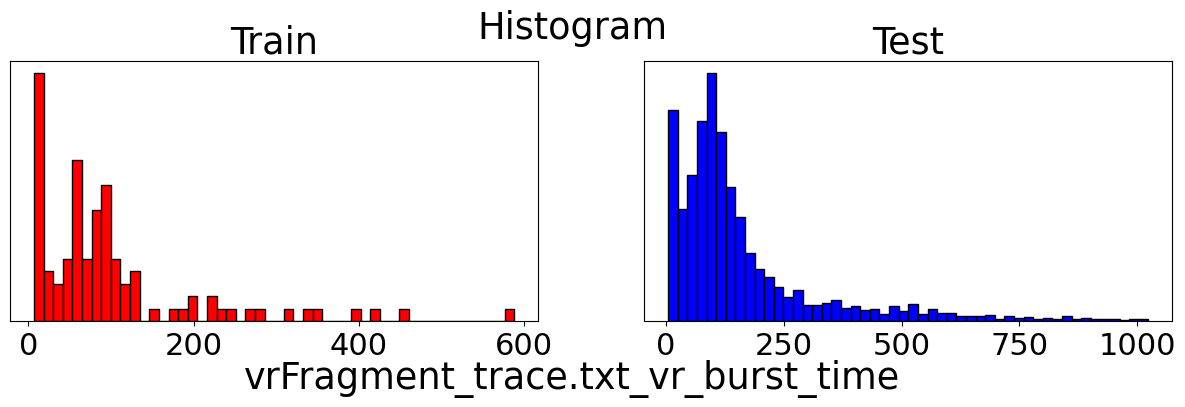

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3553600311279297
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s, v_num=69, train_loss=1.5e+4, train_mean_absolute_percentage_error=0.749, val_mean_absolute_percentage_error=0.734, val_loss=4.26e+4]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 87.88293333 132.54046667 121.33473333  11.9815      61.45453333
  94.7         89.874125    97.18307143 221.37746154 106.770125
  83.4545      79.20257143  11.26533333  13.89171429  98.2608125
  99.3316875   88.1585      55.6694     114.27253333  10.51113333
  11.88133333 127.10273333  75.15326667  25.39947059   8.44853333
 147.43575    203.777       55.7334375   77.1168125  101.89513333
 320.431       91.91421429  10.15442857  14.32786667 264.46925
  55.59813333  47.08333333  59.132      130.95573333  93.43273333
   9.90628571  80.39747059  89.25376923 238.58071429  22.23366667
 219.60208333 242.02695455 339.39823077 106.1800625   17.2235
  12.2622     197.39207143  14.47693333  48.56506667  50.294
 423.35

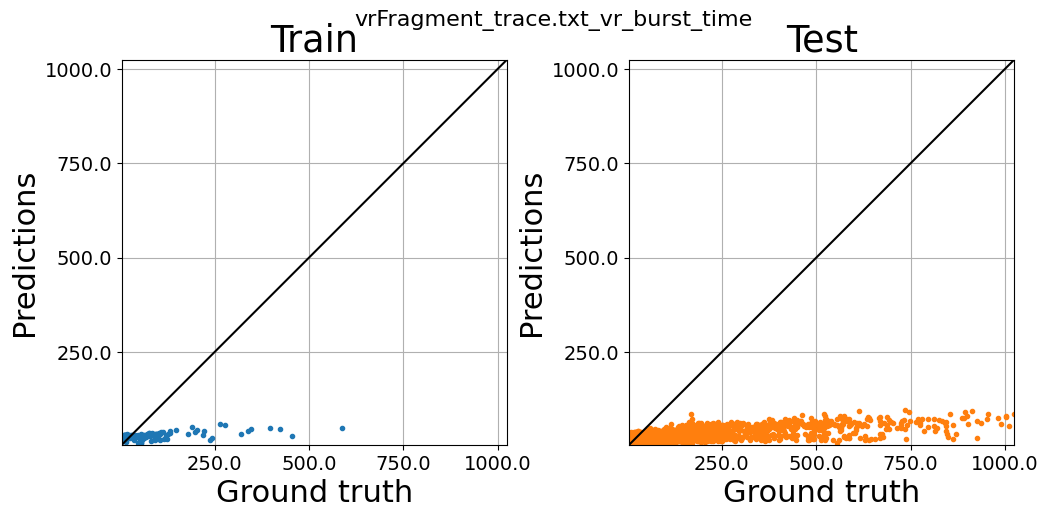



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(342110, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
After removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
(335990, 108)
(335990,)
(335990,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(167892, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

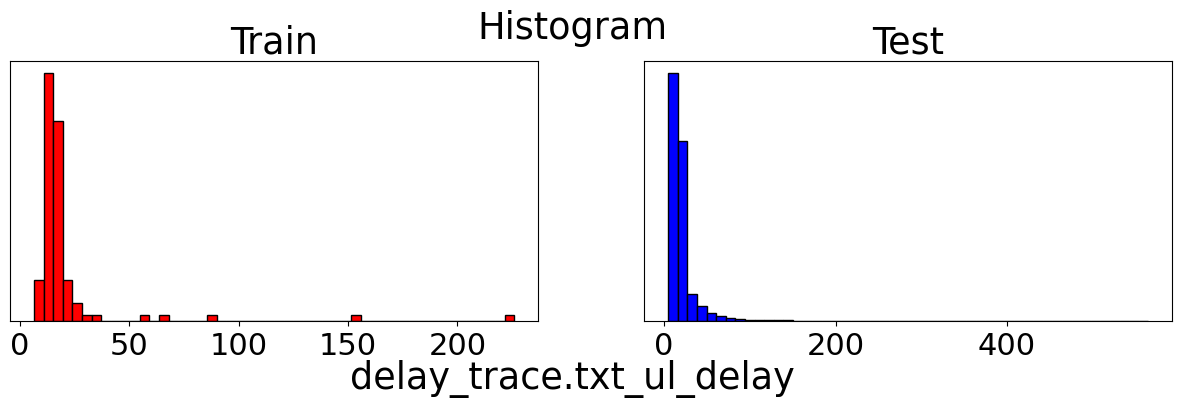

Time to process data for one learning task:  2.6897647380828857


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  0.68it/s, v_num=70, train_loss=570.0, train_mean_absolute_percentage_error=0.452, val_mean_absolute_percentage_error=0.375, val_loss=1.28e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 15.1322      12.731       10.9312      15.7316      11.9324
  17.5322      13.68175     19.1312      12.3314      36.682
  14.7318      12.7314      23.5318      18.9312     152.1334
 226.09866667  17.532       88.9312      13.9316      15.6825
  14.1312      12.531       17.1815      13.5324      19.131
  16.3314      18.131       21.732       18.9314      13.931
  15.93116667  16.5314      18.09916667  18.7318      21.933
  17.5312      18.5312      13.131       64.59833333  10.3316
  32.1322      16.532       12.5322      57.9316      12.131
  12.1316      16.5318      16.3316      11.9312      23.68125
  24.26633333  11.9312      14.1314      16.131       12.7316
  19.43125     10.3322      15.1318     

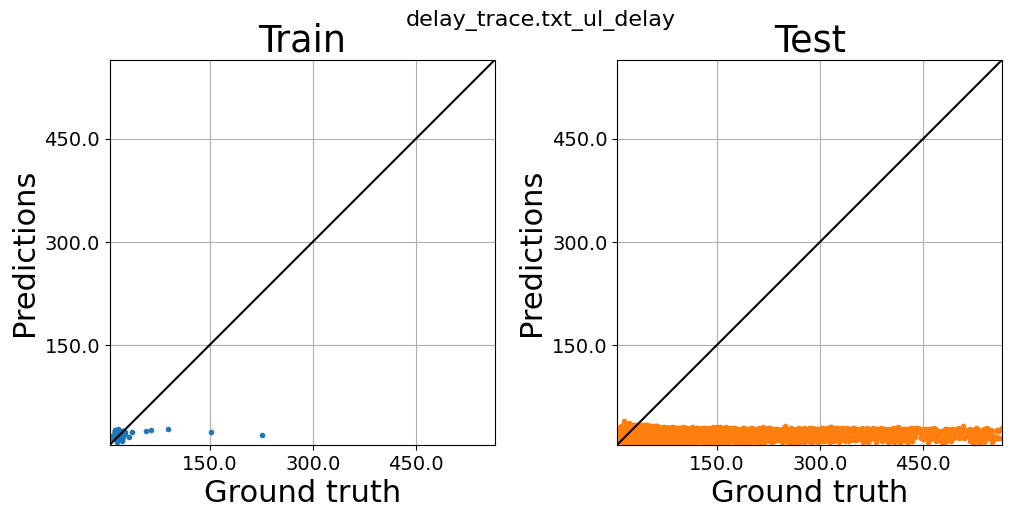



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(359433, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
After removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
(350432, 108)
(350432,)
(350432,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(179651, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

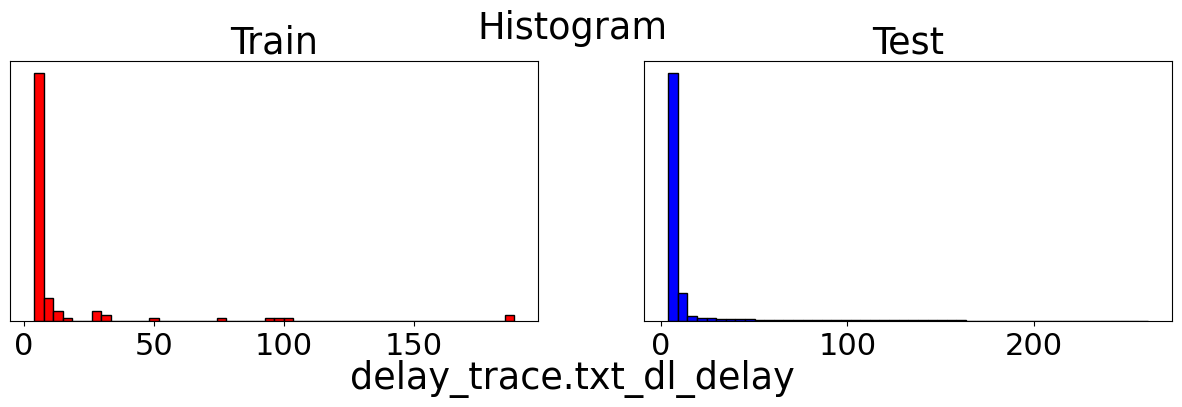

Time to process data for one learning task:  2.563194990158081


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  0.62it/s, v_num=71, train_loss=715.0, train_mean_absolute_percentage_error=1.610, val_mean_absolute_percentage_error=1.270, val_loss=1.37e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 97.199      188.799        4.499        3.999        3.999
   3.999       75.249        3.999        5.399        3.999
   7.199       11.999        3.999        3.999        3.999
 186.499        9.599        3.999        3.999        4.599
   4.999        7.599       12.599        3.999        3.999
   5.599        4.199       49.999        3.999       10.999
   3.999        3.999        3.999        3.999        4.599
   5.999       27.66566667   5.599        7.199        4.199
   4.199        3.999        7.999        4.399        4.799
   3.999        3.999        7.599        7.999       10.999
   3.999        3.999        3.999        3.999       15.199
   4.199        4.999        3.999        3.999

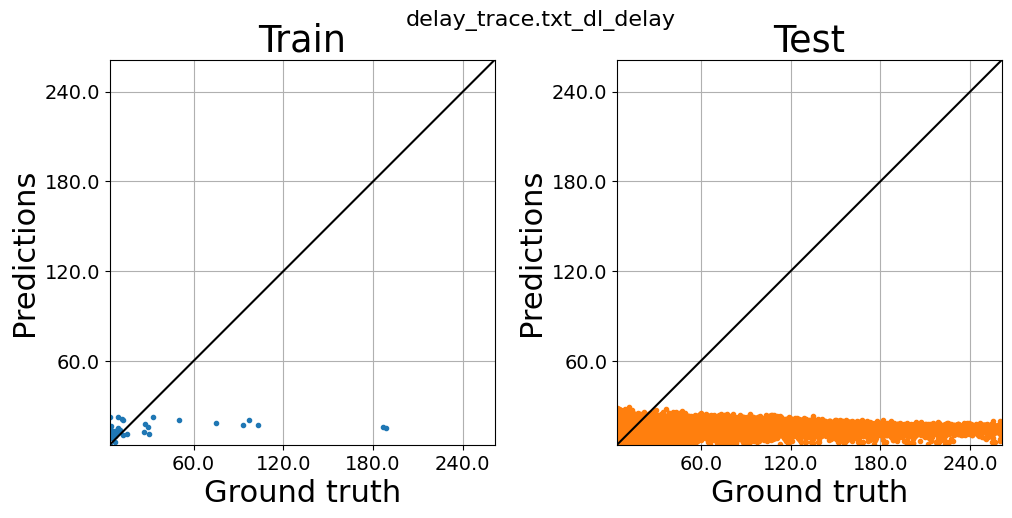



===============================  DONE  ===================================================
============================= Train set mean over runs ===================================
                                                MAE      MAPE        R2
vrFragment_trace.txt_vr_frag_thput_mbps    0.231402  1.988579  0.529411
vrFragment_trace.txt_vr_burst_thput_mbps  11.363463  2.177862  0.204007
vrFragment_trace.txt_vr_frag_time         81.713475  0.734715 -0.349018
vrFragment_trace.txt_vr_burst_time        87.794718  0.767515 -0.401004
delay_trace.txt_ul_delay                   7.688131  0.334878  0.025164
delay_trace.txt_dl_delay                  13.700678  1.429621  0.080671
=============================== Test set results =========================================
                                                               MAE  \
vrFragment_trace.txt_vr_frag_thput_mbps        [0.358 0.229 0.229]   
vrFragment_trace.txt_vr_burst_thput_mbps    [11.741 10.673 10.673]   
vrFragment_

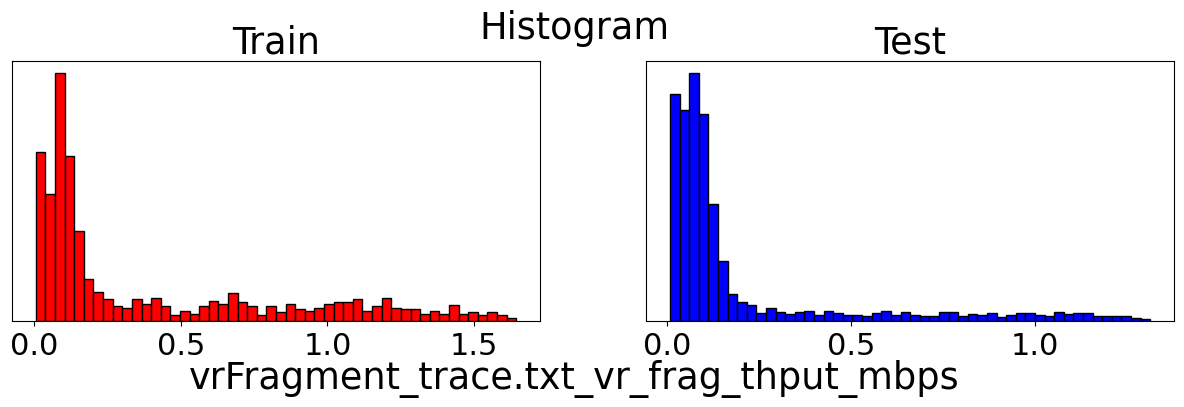

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.34555602073669434
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.01it/s, v_num=72, train_loss=0.0931, train_mean_absolute_percentage_error=2.150, val_mean_absolute_percentage_error=2.460, val_loss=0.0662]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][0.86674294 0.20439669 0.06706469 1.30571123 0.023702   0.62828394
 0.07336159 0.7331795  0.01719448 0.12355014 0.87505654 0.46478118
 0.23907677 1.32631131 0.08737237 1.02495269 0.93616607 0.61619658
 0.45889471 1.049541   0.87997199 0.07705623 1.09939026 0.09244128
 0.10690805 1.41642116 0.12116771 0.14347106 1.47040919 0.68646393
 0.08416795 1.15827233 0.85722069 1.35996193 0.13438278 0.15269867
 1.16101017 0.62312474 0.19955516 0.12982746 0.03050293 0.07027019
 0.37906034 0.08968419 0.41899609 0.02227645 0.09736251 0.02383507
 0.05431992 0.25333507 0.44020892 0.03583032 0.08215101 0.1426066
 0.85167569 1.33256853 1.14585577 0.04194774 0.0640242  0.02191295
 0.66091534 0.1035207  0.67313867 0.25776006 0.08

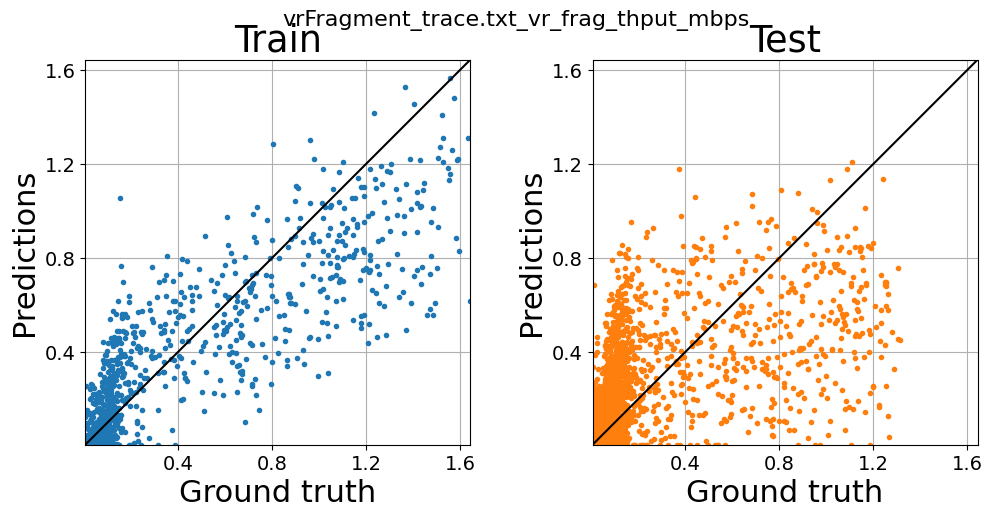



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
After removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
(6503, 108)
(6503,)
(6503,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2664  202  147  148   98]
After removing bins that are not populated enough
[0 1 2 3 4] [2664  202 

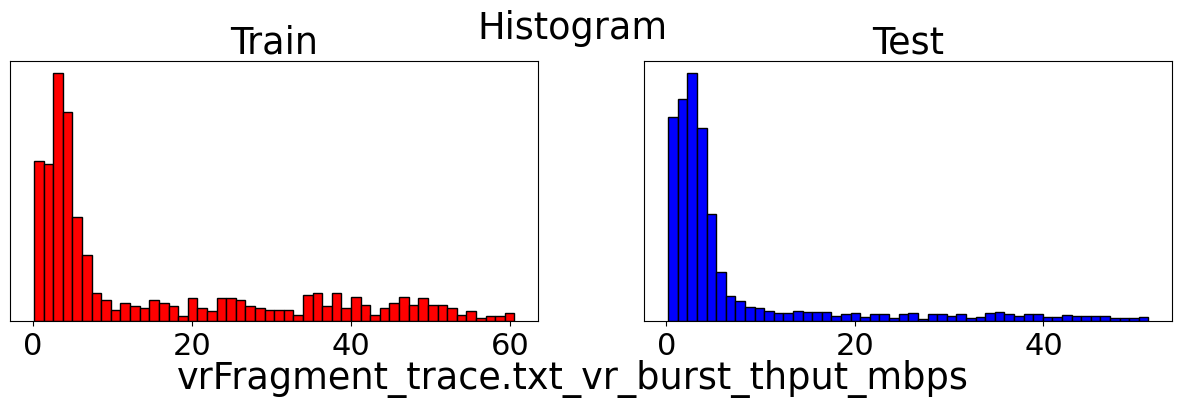

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3494555950164795
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.31it/s, v_num=73, train_loss=96.20, train_mean_absolute_percentage_error=0.926, val_mean_absolute_percentage_error=1.440, val_loss=83.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][29.0644082  35.80331444 54.67895078 17.04531206  5.63917265  0.21492751
 19.81469501  4.11441563 60.20686307  3.11059776  5.45038585  1.40946986
 44.73102291  1.03780778  7.2563398  53.15486449  1.19251658  7.17151335
  3.46159104  1.81278759  1.34210023 42.57807076  3.07208397  2.23989234
  4.73744189  4.07516054  4.31518046  4.97959983  3.7518271   3.50878412
  4.01423074 37.13397819 19.68045283 57.57673559  3.18313855  3.64455083
  2.87709769 38.64955058  8.45712382  2.05950784 12.38547992  9.91122868
  3.831203    6.46588848  4.83098889 16.04718877  2.67853732  3.03843225
  5.60967374  2.98223225 16.02296966 49.61053297  6.16809829  3.53403085
 23.98014943 33.97925279 29.57058259 45.03375149 20.0290185  

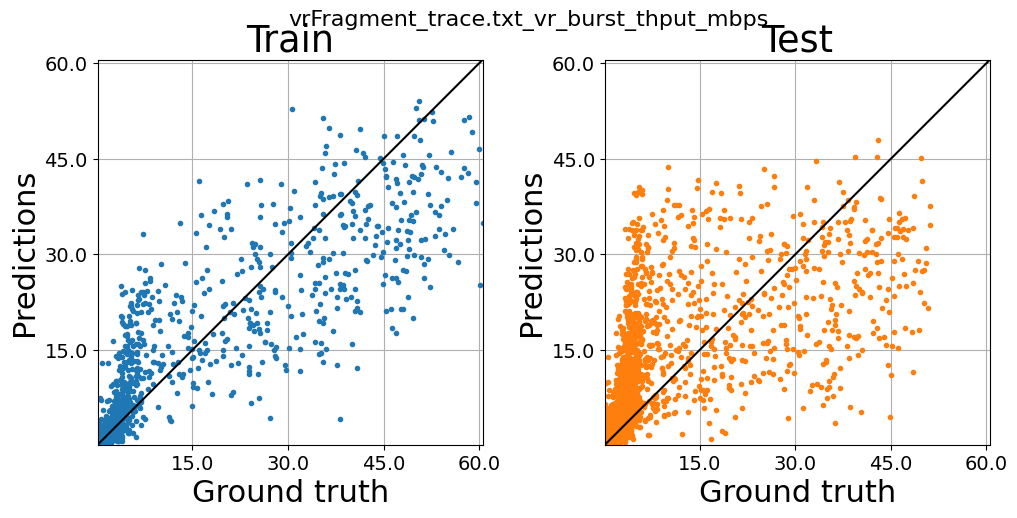



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
After removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
(6453, 108)
(6453,)
(6453,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3293, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   72   42]
After removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   

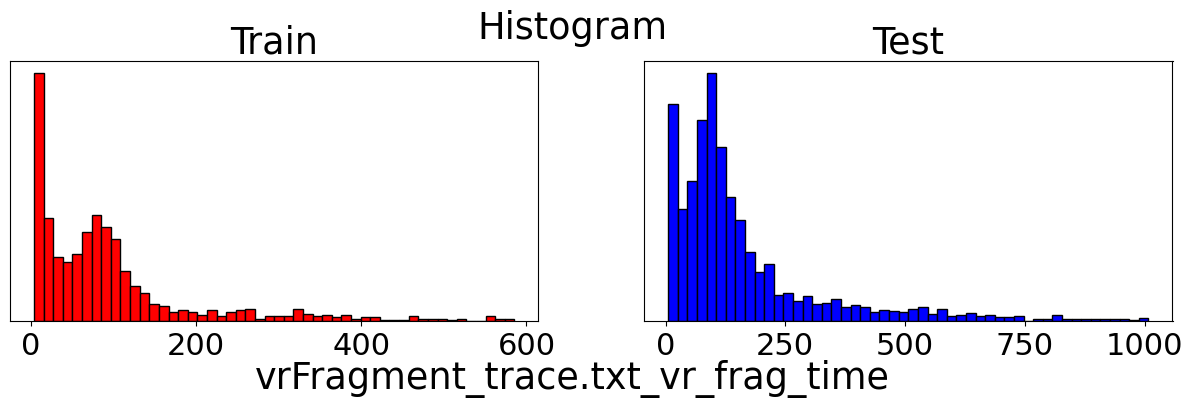

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.36129236221313477
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.64it/s, v_num=74, train_loss=2.65e+3, train_mean_absolute_percentage_error=0.666, val_mean_absolute_percentage_error=0.447, val_loss=6.75e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][  7.53220513 126.42087584 136.95522963 103.33139058 252.52193382
  10.65432601  66.69148713 272.742       26.15196396 223.64773214
  65.29897174  64.64224902 123.3876127   23.57561423 123.84714332
  12.94989858  95.1472425  117.03295808  38.43942323 392.07216667
  15.41351937  26.50212278  72.04372907  70.50928964 297.63986364
  97.90008269  42.80290368  12.33984045 235.4271989   28.47707958
  82.75527083  60.3374896   14.99727563 104.39239831  79.98234459
 103.61128412  11.33593843 269.25627647  16.2916044   10.96805106
  48.73365923 115.78269775  13.72521923 184.39494118 109.97094953
  50.43798885  11.72767027  54.61560285  53.37566925   6.0173975
  53.89388224 143.12288302 184.56264039   8.34363842  94.94

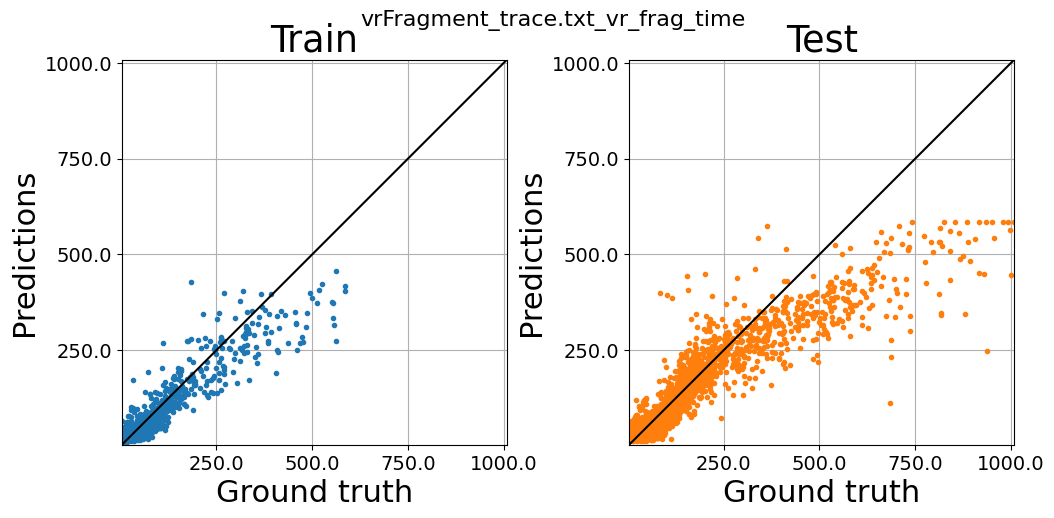



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
After removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
(6444, 108)
(6444,)
(6444,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186   71   38]
After removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186  

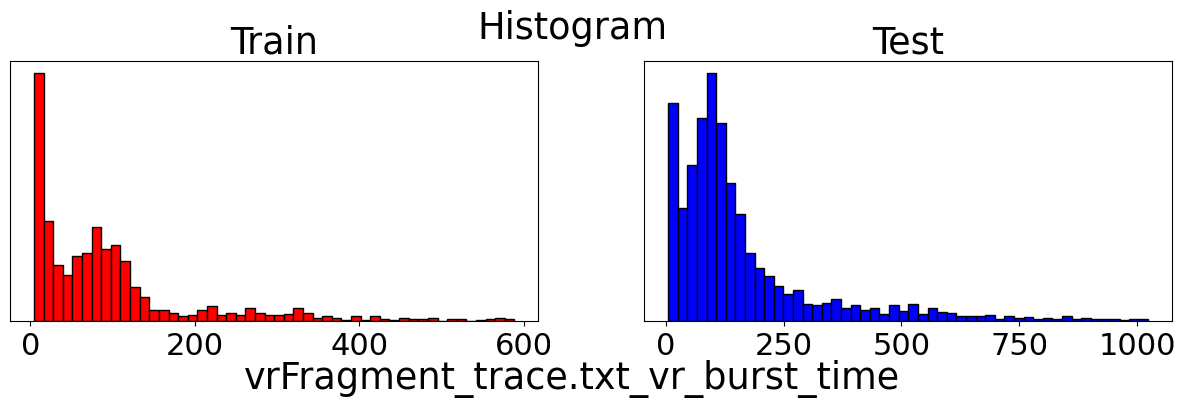

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.39838361740112305
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.31it/s, v_num=75, train_loss=2.46e+3, train_mean_absolute_percentage_error=0.705, val_mean_absolute_percentage_error=0.493, val_loss=6.32e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 13.60073333  97.18307143 357.76744444  12.65886667 108.91021429
   6.95871429  17.5874375   99.68223077 187.1311875   25.648125
 191.1779     101.89513333  11.40375     96.5024375   14.576
  63.55858824  13.20978571  49.23664286 115.32392857  66.5232
  34.63807143  16.07226667  21.53770588  95.50746667  27.29425
  11.93073333   7.957      250.4055      87.34346667   7.19786667
 142.487      192.51357143 114.0148      46.7355      36.5445
  21.07392857  19.8381875  242.34875     29.07475     79.20257143
 342.88547059 119.439       93.89566667 130.00264286   6.53426667
  19.75366667  78.04669231 271.732       12.0308      41.77283333
  18.83513333  66.0193125    8.6606      31.4785     284.35536364
  55.87453

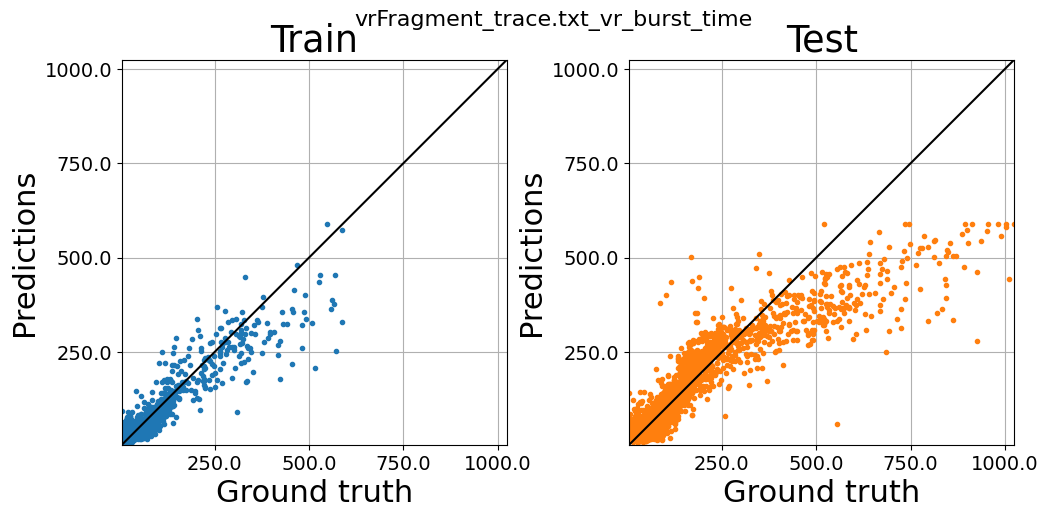



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(342110, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
After removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
(335990, 108)
(335990,)
(335990,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(167892, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

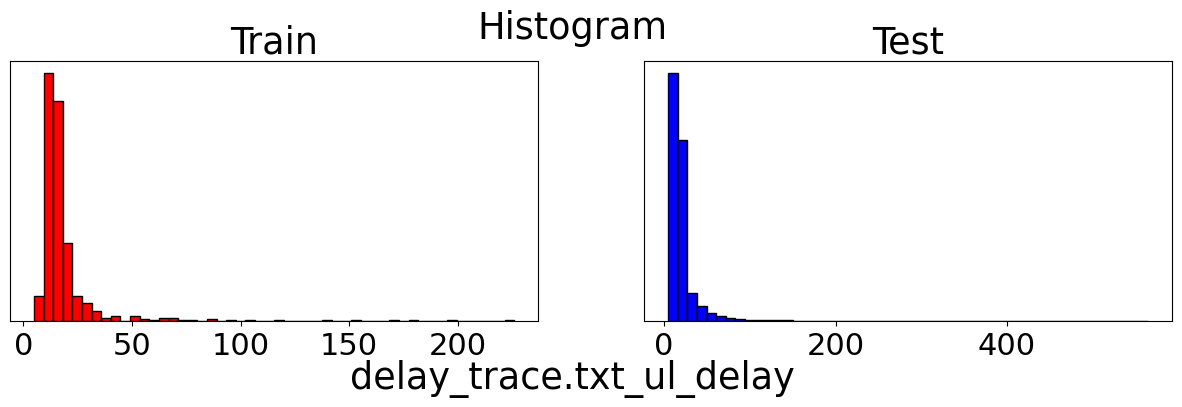

Time to process data for one learning task:  2.389807939529419


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.11it/s, v_num=76, train_loss=206.0, train_mean_absolute_percentage_error=0.368, val_mean_absolute_percentage_error=0.290, val_loss=1.12e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 12.7316      14.3314      13.131       12.1312      13.1318
 226.09866667  15.7318      15.3314      41.1312      16.1316
  16.9316     118.181       12.7316      20.1312      59.183
  16.3312     152.1334      30.9314      13.3314      17.5312
  11.9314      17.9316      11.931       22.5312      17.931
  25.2655      12.5332      11.9328      16.59883333  16.1328
  17.598       32.1322      17.3316      16.5316      14.9322
  43.5314      14.531       49.6815      14.9312      15.3312
  17.5314      13.3312      14.7318      11.9322      14.9316
   8.7324      14.9316      16.132       15.432       23.7328
  16.1312      11.5312      13.331       14.7314      10.3314
  32.9316      14.7314      32.432    

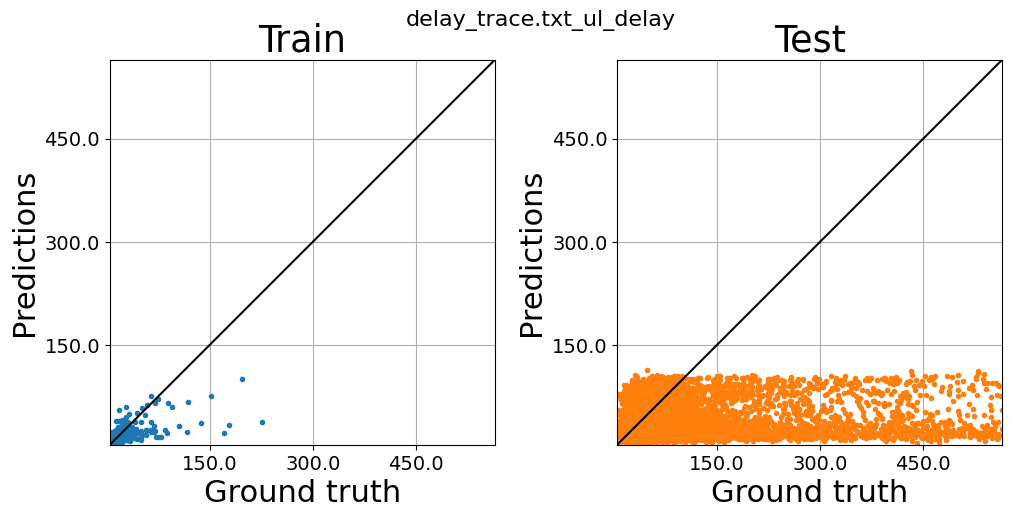



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(359433, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
After removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
(350432, 108)
(350432,)
(350432,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(179651, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

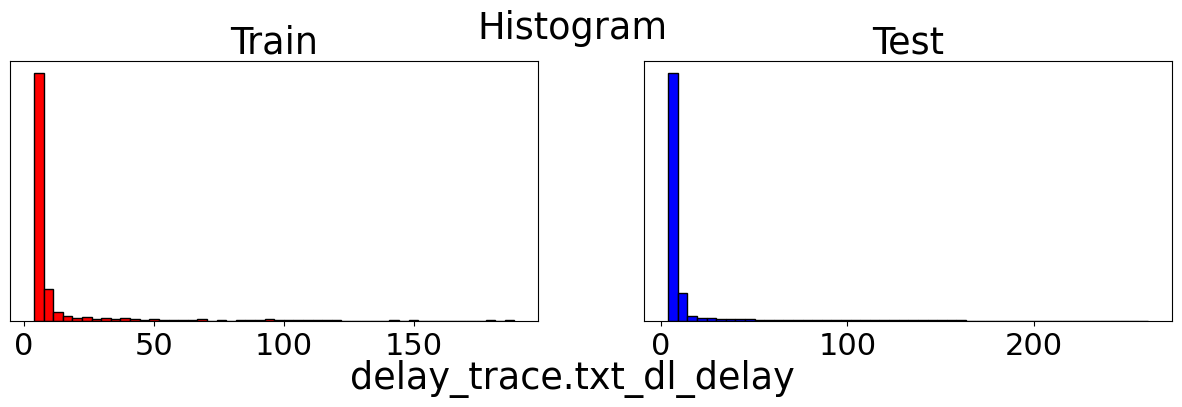

Time to process data for one learning task:  2.5836377143859863


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.77it/s, v_num=77, train_loss=334.0, train_mean_absolute_percentage_error=1.010, val_mean_absolute_percentage_error=0.855, val_loss=530.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 32.999       22.33233333  12.999        4.199        3.999
  74.999        3.999        3.999       40.499        4.999
  97.999        7.999        3.999        3.999        5.999
   5.399        5.399        3.999       15.83233333  27.66566667
  12.199        3.999        5.399        3.999        3.999
   3.999        6.999        7.199        4.249        5.199
   3.999        3.999        3.999        3.999       11.33233333
   4.999        3.999       10.999        5.399        6.399
  28.599        3.999        3.999        3.999        5.799
   3.999        3.999      103.199       10.999        5.599
   4.599        3.999        9.799        3.999        5.399
   3.999        3.999        4.399   

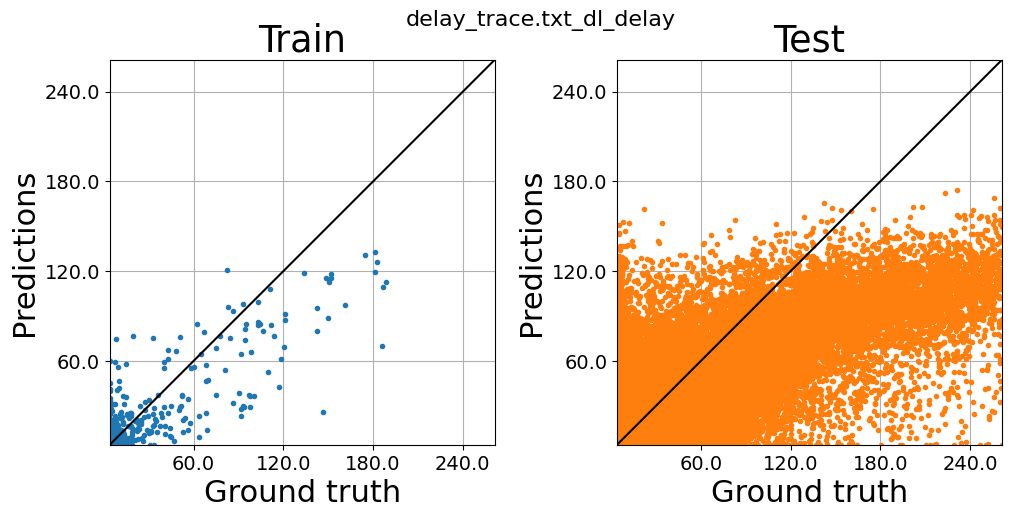



===============================  DONE  ===================================================
Random iteration:  1
# train runs used  2
# test runs used  1
Concatenating runs:  [11 12]
Time to read csv file for run:  2.720048189163208
Loaded run 11
Time to read csv file for run:  2.6769940853118896
Loaded run 12
Concatenating runs:  [13]
Time to read csv file for run:  2.834059000015259
Loaded run 13
Time to read data:  23.73435616493225
Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4109  684  636  719  360]
After removing bins that are not populated enough
[0 1 2 3 4] [4109  684  636  719  360]
(6508, 108)
(6508,)
(6508,)
Dropping rows for which this learning_tasks labe

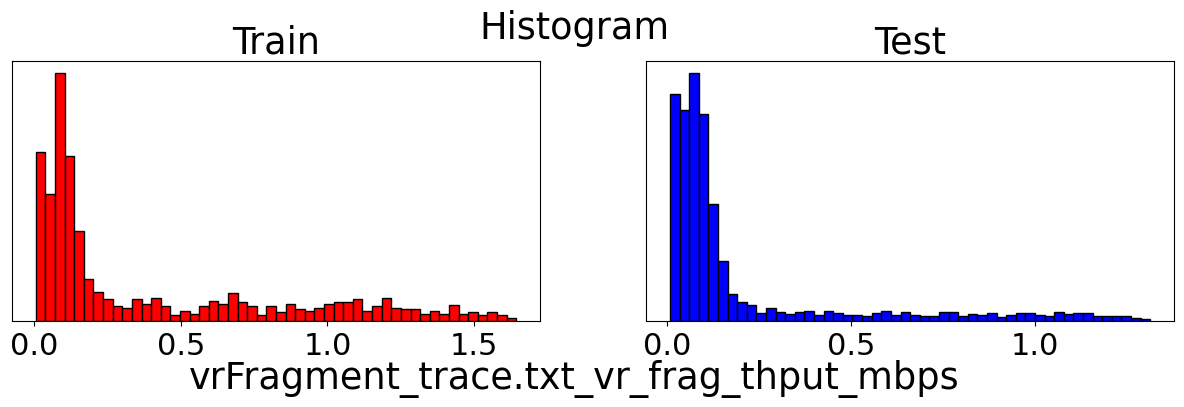

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.36348628997802734
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 10.95it/s, v_num=78, train_loss=0.0931, train_mean_absolute_percentage_error=2.150, val_mean_absolute_percentage_error=2.460, val_loss=0.0662]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][0.86674294 0.20439669 0.06706469 1.30571123 0.023702   0.62828394
 0.07336159 0.7331795  0.01719448 0.12355014 0.87505654 0.46478118
 0.23907677 1.32631131 0.08737237 1.02495269 0.93616607 0.61619658
 0.45889471 1.049541   0.87997199 0.07705623 1.09939026 0.09244128
 0.10690805 1.41642116 0.12116771 0.14347106 1.47040919 0.68646393
 0.08416795 1.15827233 0.85722069 1.35996193 0.13438278 0.15269867
 1.16101017 0.62312474 0.19955516 0.12982746 0.03050293 0.07027019
 0.37906034 0.08968419 0.41899609 0.02227645 0.09736251 0.02383507
 0.05431992 0.25333507 0.44020892 0.03583032 0.08215101 0.1426066
 0.85167569 1.33256853 1.14585577 0.04194774 0.0640242  0.02191295
 0.66091534 0.1035207  0.67313867 0.25776006 0.08

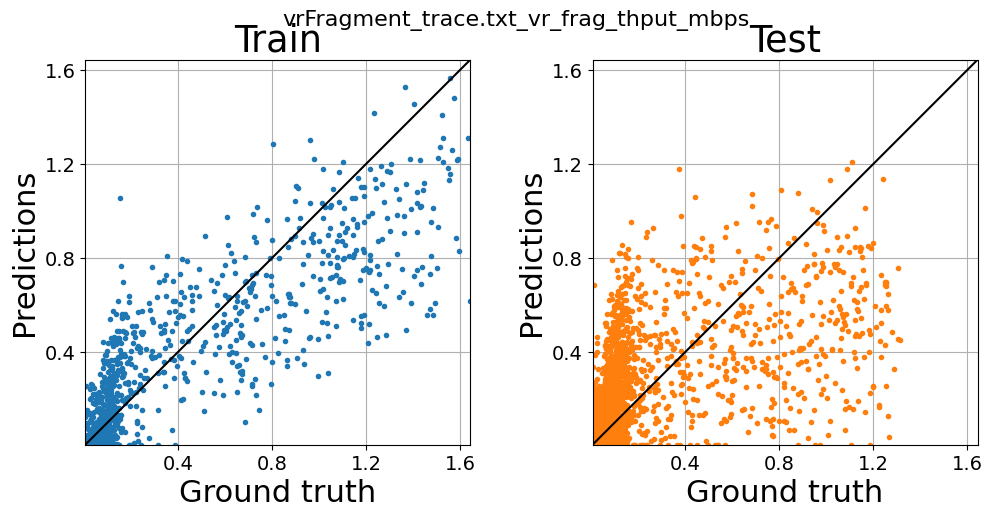



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
After removing bins that are not populated enough
[0 1 2 3 4] [4106  632  670  695  400]
(6503, 108)
(6503,)
(6503,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2664  202  147  148   98]
After removing bins that are not populated enough
[0 1 2 3 4] [2664  202 

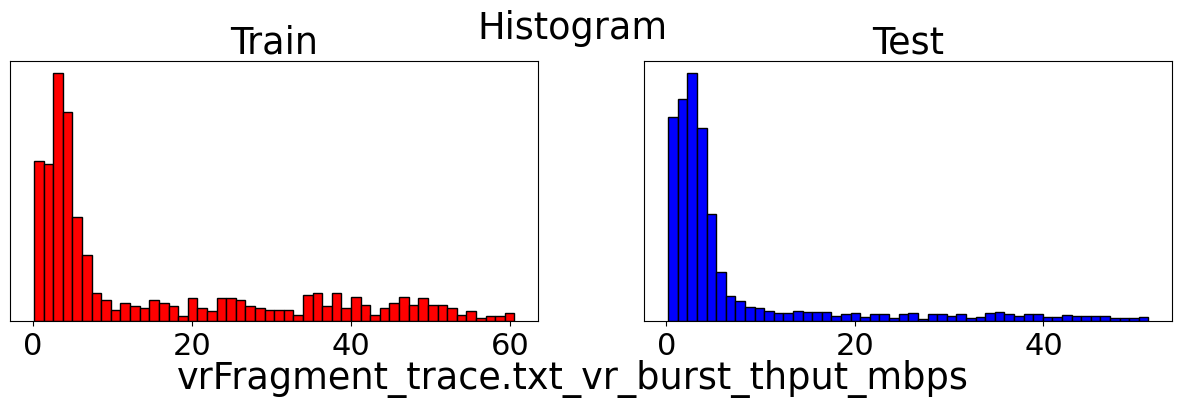

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.35329556465148926
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.33it/s, v_num=79, train_loss=96.20, train_mean_absolute_percentage_error=0.926, val_mean_absolute_percentage_error=1.440, val_loss=83.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][29.0644082  35.80331444 54.67895078 17.04531206  5.63917265  0.21492751
 19.81469501  4.11441563 60.20686307  3.11059776  5.45038585  1.40946986
 44.73102291  1.03780778  7.2563398  53.15486449  1.19251658  7.17151335
  3.46159104  1.81278759  1.34210023 42.57807076  3.07208397  2.23989234
  4.73744189  4.07516054  4.31518046  4.97959983  3.7518271   3.50878412
  4.01423074 37.13397819 19.68045283 57.57673559  3.18313855  3.64455083
  2.87709769 38.64955058  8.45712382  2.05950784 12.38547992  9.91122868
  3.831203    6.46588848  4.83098889 16.04718877  2.67853732  3.03843225
  5.60967374  2.98223225 16.02296966 49.61053297  6.16809829  3.53403085
 23.98014943 33.97925279 29.57058259 45.03375149 20.0290185  

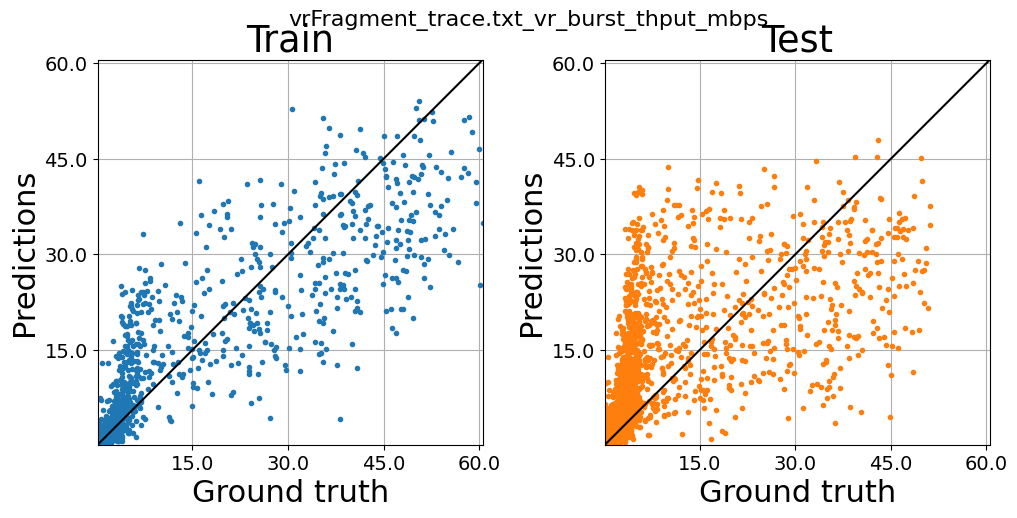



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_frag_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6587, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
After removing bins that are not populated enough
[0 1 2 3 4] [5369  615  331  138   55]
(6453, 108)
(6453,)
(6453,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3293, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   72   42]
After removing bins that are not populated enough
[0 1 2 3 4] [2532  431  183   

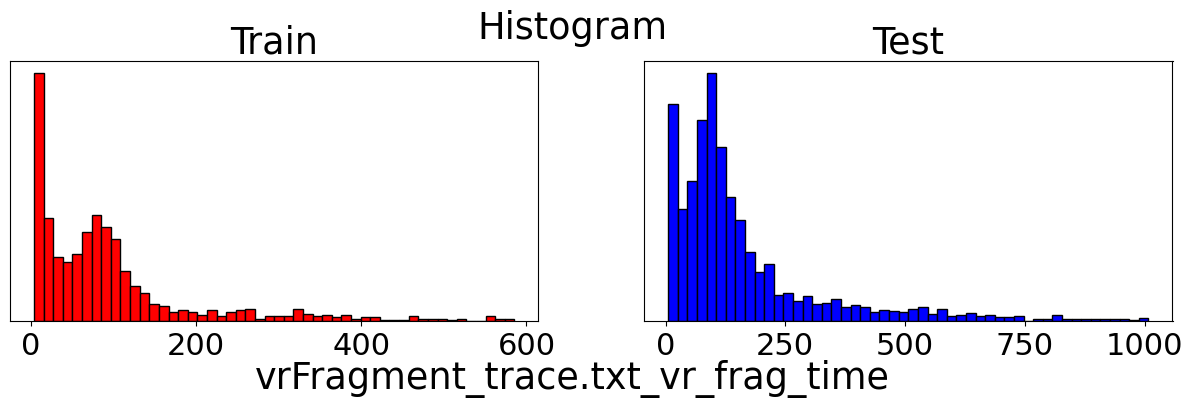

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.35407352447509766
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.31it/s, v_num=80, train_loss=2.65e+3, train_mean_absolute_percentage_error=0.666, val_mean_absolute_percentage_error=0.447, val_loss=6.75e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][  7.53220513 126.42087584 136.95522963 103.33139058 252.52193382
  10.65432601  66.69148713 272.742       26.15196396 223.64773214
  65.29897174  64.64224902 123.3876127   23.57561423 123.84714332
  12.94989858  95.1472425  117.03295808  38.43942323 392.07216667
  15.41351937  26.50212278  72.04372907  70.50928964 297.63986364
  97.90008269  42.80290368  12.33984045 235.4271989   28.47707958
  82.75527083  60.3374896   14.99727563 104.39239831  79.98234459
 103.61128412  11.33593843 269.25627647  16.2916044   10.96805106
  48.73365923 115.78269775  13.72521923 184.39494118 109.97094953
  50.43798885  11.72767027  54.61560285  53.37566925   6.0173975
  53.89388224 143.12288302 184.56264039   8.34363842  94.94

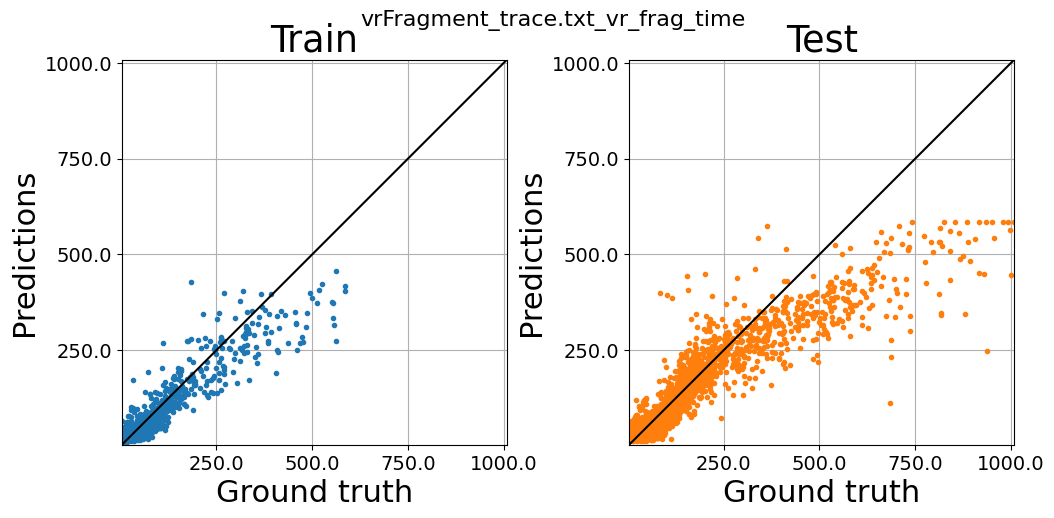



===============================  DONE  ===================================================
Learning task:  vrFragment_trace.txt_vr_burst_time task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(6581, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
After removing bins that are not populated enough
[0 1 2 3 4] [5357  608  337  142   59]
(6444, 108)
(6444,)
(6444,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(3292, 118)
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186   71   38]
After removing bins that are not populated enough
[0 1 2 3 4] [2554  410  186  

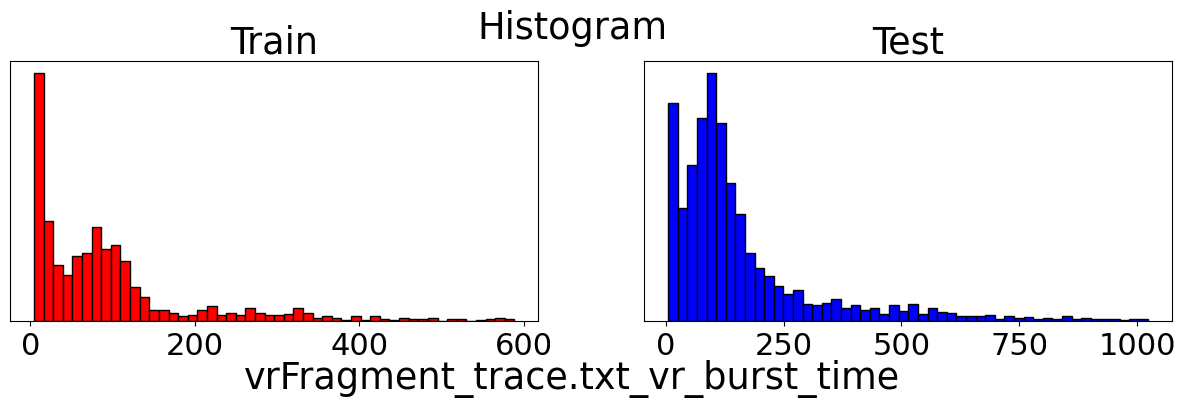

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Time to process data for one learning task:  0.3797874450683594
   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.57it/s, v_num=81, train_loss=2.46e+3, train_mean_absolute_percentage_error=0.705, val_mean_absolute_percentage_error=0.493, val_loss=6.32e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 13.60073333  97.18307143 357.76744444  12.65886667 108.91021429
   6.95871429  17.5874375   99.68223077 187.1311875   25.648125
 191.1779     101.89513333  11.40375     96.5024375   14.576
  63.55858824  13.20978571  49.23664286 115.32392857  66.5232
  34.63807143  16.07226667  21.53770588  95.50746667  27.29425
  11.93073333   7.957      250.4055      87.34346667   7.19786667
 142.487      192.51357143 114.0148      46.7355      36.5445
  21.07392857  19.8381875  242.34875     29.07475     79.20257143
 342.88547059 119.439       93.89566667 130.00264286   6.53426667
  19.75366667  78.04669231 271.732       12.0308      41.77283333
  18.83513333  66.0193125    8.6606      31.4785     284.35536364
  55.87453

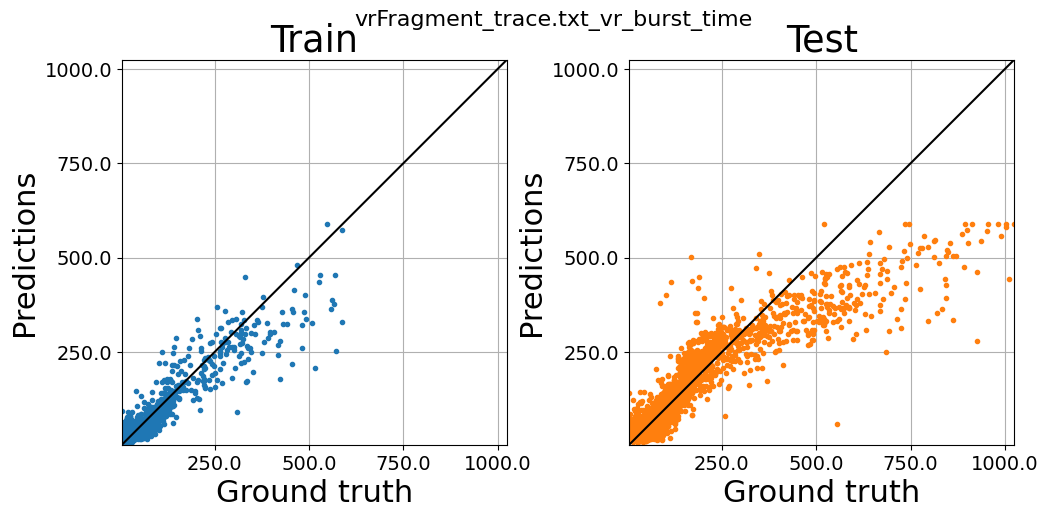



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_ul_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(342110, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
After removing bins that are not populated enough
[0 1 2 3 4] [335990   1321    660    447    270]
(335990, 108)
(335990,)
(335990,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(167892, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

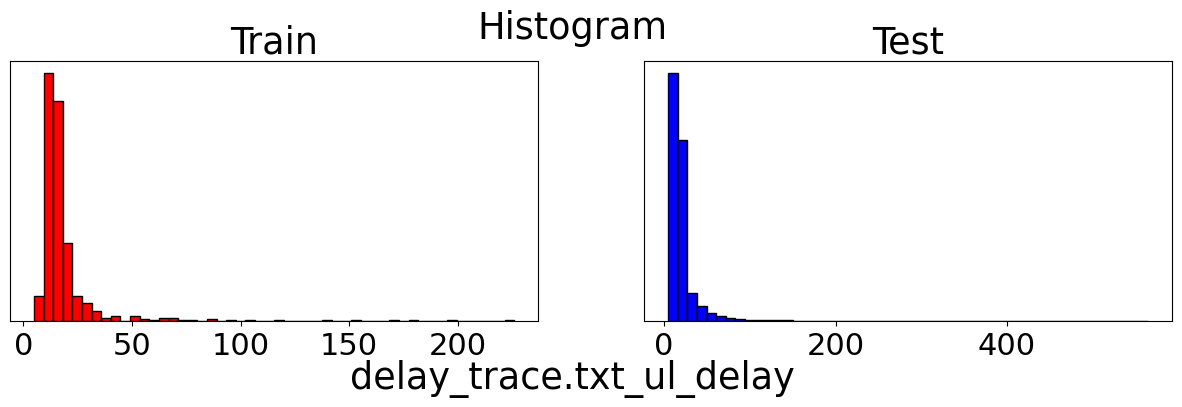

Time to process data for one learning task:  2.3944833278656006


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.39it/s, v_num=82, train_loss=206.0, train_mean_absolute_percentage_error=0.368, val_mean_absolute_percentage_error=0.290, val_loss=1.12e+3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                                                                                                                                                                       | 0/? [00:00<?, ?it/s][ 12.7316      14.3314      13.131       12.1312      13.1318
 226.09866667  15.7318      15.3314      41.1312      16.1316
  16.9316     118.181       12.7316      20.1312      59.183
  16.3312     152.1334      30.9314      13.3314      17.5312
  11.9314      17.9316      11.931       22.5312      17.931
  25.2655      12.5332      11.9328      16.59883333  16.1328
  17.598       32.1322      17.3316      16.5316      14.9322
  43.5314      14.531       49.6815      14.9312      15.3312
  17.5314      13.3312      14.7318      11.9322      14.9316
   8.7324      14.9316      16.132       15.432       23.7328
  16.1312      11.5312      13.331       14.7314      10.3314
  32.9316      14.7314      32.432    

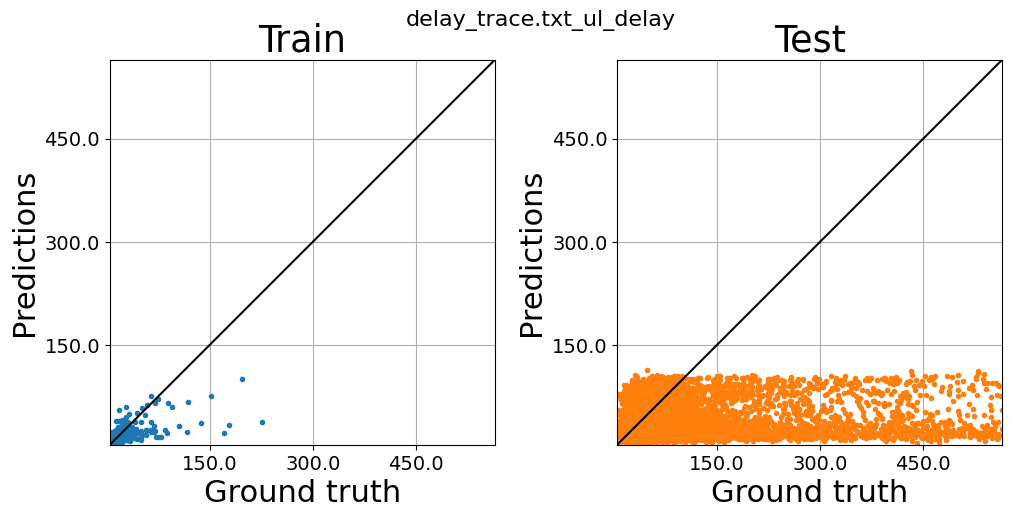



===============================  DONE  ===================================================
Learning task:  delay_trace.txt_dl_delay task type:  reg
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(359433, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
After removing bins that are not populated enough
[0 1 2 3 4] [329587  15008   5837   3155   1750]
(350432, 108)
(350432,)
(350432,)
Dropping rows for which this learning_tasks label is NA, since there is no ground truth
(179651, 118)
NOTE: clipping all rows with delay values >  5000
NOTE: removing samples that are above the 99th percentile
NOTE: stratifying regression samples using 5 bins
bin_and_remove_outliers
Before removing bins that are not populated enoug

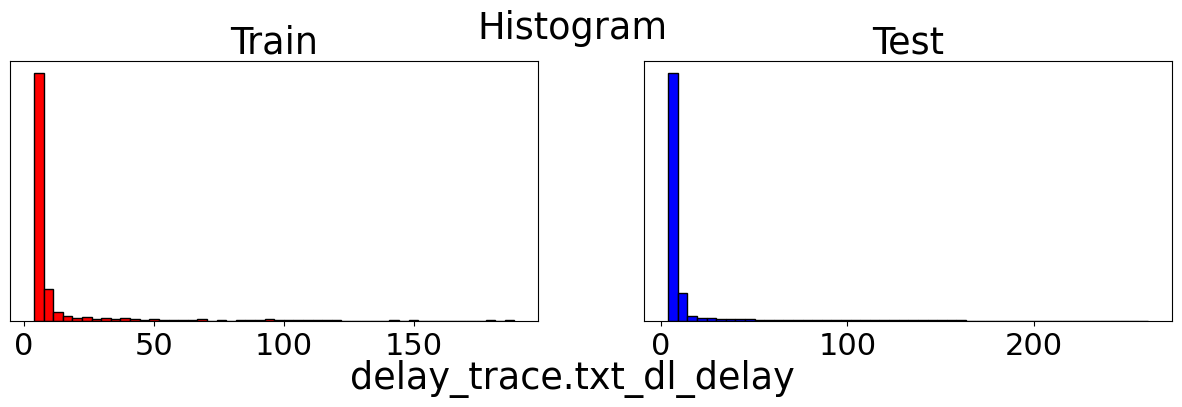

Time to process data for one learning task:  2.575171947479248


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params | Mode 
----------------------------------------------------------------------
0 | task_loss_fn             | MSELoss          | 0      | train
1 | mask_loss_fn             | BCELoss          | 0      | train
2 | categorical_feature_loss | CrossEntropyLoss | 0      | train
3 | continuous_feature_loss  | MSELoss          | 0      | train
4 | model                    | DAE              | 1.2 M  | train
----------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


   | Name                                      | Type             | Params | Mode 
----------------------------------------------------------------------------------------
0  | task_loss_fn                              | MSELoss          | 0      | train
1  | mask_loss_fn                              | BCELoss          | 0      | train
2  | categorical_feature_loss                  | CrossEntropyLoss | 0      | train
3  | continuous_feature_loss                   | MSELoss          | 0      | train
4  | model                                     | DAE              | 1.2 M  | train
5  | model._DAE__encoder                       | MLP              | 846 K  | train
6  | model._DAE__encoder.linear_0              | Linear           | 55.8 K | train
7  | model._DAE__encoder.batchnorm_0           | BatchNorm1d      | 1.0 K  | train
8  | model._DAE__encoder.relu_0                | ReLU             | 0      | train
9  | model._DAE__encoder.dropout_0             | Dropout          | 0      | trai

In [ ]:
# Erase the contents of the results file into which we append as we loop through 
open('train_results.csv', 'w').close()
open('test_results.csv', 'w').close()

# Iterate over different number of labeled samples 
for label_no in num_samples_list:
    
    EXP_PARAM['label_no'] = label_no
    print('==========================================================================')
    print('NUM. LABELLED SAMPLES: ', label_no)
    print('==========================================================================')

    # Aggregate results over runs
    train_results = pd.DataFrame(index=learning_tasks, columns=['MAE', 'MAPE', 'R2']) # or ['ACC', 'F1', 'ROC_AUC']
    test_results = pd.DataFrame(index=learning_tasks, columns=['MAE', 'MAPE', 'R2']) # or ['ACC', 'F1', 'ROC_AUC']
    # Apply the function to each cell in the DataFrame
    train_results = train_results.applymap(lambda x: create_nan_array(EXP_PARAM['num_rand_runs']))
    test_results = test_results.applymap(lambda x: create_nan_array(EXP_PARAM['num_rand_runs']))

    # Iterate over different random initializations
    for rs in range(0, EXP_PARAM['num_rand_runs']):
        read_data_start_time = time.time()
        print('==========================================================================')
        print('Random iteration: ', rs)
        print('==========================================================================')
                    
        # Randomly select which runs shall be train and which shall be test 
        shuffled_run_ind = np.random.permutation(len(train_test_run_nums))
        train_runs = train_test_run_nums[shuffled_run_ind[:num_train_runs]]
        test_runs = train_test_run_nums[shuffled_run_ind[num_train_runs:]]
        print('# train runs used ', len(train_runs))
        print('# test runs used ', len(test_runs))
        
        # Read the runs from files and creater a train and test dataset 
        train_data = read_and_concatenate_runs (train_runs, dataset_folder, train_slice, network_info, time_step_size, 
                                               use_all_feats, drop_col_substr, learning_tasks, shift_samp_for_predict, 
                                               impute_method, sum_cols_substr, all_learning_tasks_in_data)
        test_data = read_and_concatenate_runs (test_runs, dataset_folder, test_slice, network_info, time_step_size, 
                                              use_all_feats, drop_col_substr, learning_tasks, shift_samp_for_predict, 
                                              impute_method, sum_cols_substr, all_learning_tasks_in_data)
        print('Time to read data: ', time.time() - read_data_start_time)
        for idx, learning_task in enumerate(learning_tasks):
            
            task_it_start_time = time.time()
            print('================================================================================')
            print('Learning task: ', learning_task, 'task type: ', learning_task_types[idx] )
            print('================================================================================')
    
            learning_task_type = learning_task_types[idx]
            is_regression = learning_task_type == 'reg'
            learning_task_type_ff = 'regression'
            if learning_task_type == 'clas':
                learning_task_type_ff = 'classification'

            X_train, y_train, train_strat_array, X_feats, continuous_cols, categorical_cols = make_data_sup_model_ready (train_data, learning_task, learning_task_type,
                                                                                     all_learning_tasks_in_data, bitrate_levels, 
                                                                                     clip_outliers, delay_clip_th)
            X_test, y_test, test_strat_array, _ , _, _= make_data_sup_model_ready (test_data, learning_task, learning_task_type, 
                                                             all_learning_tasks_in_data, bitrate_levels, 
                                                             clip_outliers, delay_clip_th)
            
            # Sample a subset of the train samples to be equal to the num of labelled samples we need
            sample_size = EXP_PARAM['label_no']
            if len(y_train) <= EXP_PARAM['label_no']:
                print("\n\nWARNING !!!!\n\nAsked to sample from train set of size "+str(len(y_train))+ 
                      " a number greater than or equal to its size "+str(EXP_PARAM['label_no']))
                print('Going to just take as many samples as available, No need to random sample')
            else:
                # This functions helps me random sample with stratification 
                X_train, _, y_train, _ = train_test_split(X_train, y_train,
                                                                      train_size=EXP_PARAM['label_no'], shuffle=True,
                                                                      stratify=train_strat_array)
                
            # create a validation set from the test set 
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                          test_size=0.25, shuffle=True, 
                                                          stratify=test_strat_array)  
            
            print('Train data shape ' + str(X_train.shape))
            print('Test data shape ' + str(X_test.shape))
            print('Val data shape ' + str(X_val.shape))
    
            plot_hist_of_y(y_train, y_test, learning_task)
             
            print('Time to process data for one learning task: ', time.time() - task_it_start_time)
            
            #=============================================== Train and test the model ==================================
        
            start_time = time.time()
    
            if use_pretrained_model:
                # get the latent representations from pretrained model
                # Load the pretrained model and scaler 
                # Load the saved MinMaxScaler object from the file
                with open(models_folder + scaler_to_load_name, 'rb') as f:
                    val_scaler = pickle.load(f)

                X_train = val_scaler.transform(X_train).copy()
                X_test = val_scaler.transform(X_test).copy()
                X_val = val_scaler.transform(X_val).copy()

                # Need to reset DAE config for every learning task 
                if pretrain_model_to_load_type == 's3l_dae':
                    
                    # Reset the config of DAE based on learning task  
                    #config = DAEConfig (input_dim=X_train.shape[1], output_dim=y_train.shape[1],
                    #                    task=learning_task_type_ff, 
                    #                    loss_fn=s3l_sup_mlp['loss'][learning_task_type], 
                    #                    metric=s3l_sup_mlp['metric'][learning_task_type], metric_hparams={})
                    # load the model
                    model = s3l_dae_load(models_folder+pretrain_model_to_load_name+'.ckpt')
                    # I think this is a DAELightning object
                    #model = s3l_dae_load('example.ckpt')
                    print(ModelSummary(model, max_depth=-1))
                    # class 'ts3l.pl_modules.dae_lightning.DAELightning'
                    # set model to second phase
                    model.set_second_phase(freeze_encoder=freeze_encoder)
                    # Set the config parameters needed for second phase
                    #model.set_second_phase_config(config) 
                    # Turn the numpy X arrays back into pandas because thats what the s3l library wants 
                    X_train = pd.DataFrame(X_train, columns=X_feats)
                    X_val = pd.DataFrame(X_val, columns=X_feats)
                    X_test = pd.DataFrame(X_test, columns=X_feats)
                    
                    train_ds = DAEDataset(X = X_train, Y = y_train, is_regression=is_regression,
                                          continuous_cols=continuous_cols, category_cols=categorical_cols)
                    valid_ds = DAEDataset(X = X_val, Y = y_val, is_regression=is_regression,
                                          continuous_cols=continuous_cols, category_cols=categorical_cols)
                    datamodule = TS3LDataModule(train_ds, valid_ds, is_regression=is_regression,
                                                batch_size = s3l_sup_mlp['batch_size'], train_sampler="random")
                    
                    sup_trainer = Trainer(accelerator = 'gpu', 
                                          max_epochs = s3l_sup_mlp['max_epochs'], 
                                          num_sanity_val_steps = 2, 
                                          callbacks=[MyProgressBar()], 
                                          default_root_dir=models_folder+suptrain_model_to_save_name)
                    sup_trainer.fit(model, datamodule)
                    print(ModelSummary(model, max_depth=-1))
                    # Evaluation
                    test_ds = DAEDataset(X_test, category_cols=categorical_cols, 
                                         continuous_cols=continuous_cols)
                    test_dl = DataLoader(test_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(test_ds))
                    train_ds = DAEDataset(X_train, continuous_cols=continuous_cols, 
                                          category_cols=categorical_cols)
                    train_dl = DataLoader(train_ds, s3l_sup_mlp['batch_size'], 
                                         shuffle=False, sampler = SequentialSampler(train_ds))
                    
                else:    
                    print('Do not know model type')
                    
                if learning_task_type == 'reg':
                    yhat_test = sup_trainer.predict(model, test_dl)
                    yhat_test = torch.concat([out.cpu() for out in yhat_test]).squeeze()
                    yhat_train = sup_trainer.predict(model, train_dl)
                    yhat_train = torch.concat([out.cpu() for out in yhat_train]).squeeze()
                    print(y_train)
                    print(yhat_train)
                    # Clip predictions to the range of the training data
                    print('NOTE: Clipping the predictions to be within the range of the ground-truth values')
                    yhat_train = np.clip(yhat_train, y_train.min(), y_train.max())
                    yhat_test = np.clip(yhat_test, y_train.min(), y_train.max())
                    print(yhat_train)
                     
                else: #'clas'
                    yhat_train_a = sup_trainer.predict(model, train_dl)
                    yhat_train_proba = F.softmax(torch.concat([out.cpu() for out in yhat_train_a]).squeeze(),dim=1)
                    yhat_train = yhat_train_proba.argmax(1)
                    yhat_test_a = sup_trainer.predict(model, test_dl)
                    yhat_test_proba = F.softmax(torch.concat([out.cpu() for out in yhat_test_a]).squeeze(),dim=1)
                    yhat_test = yhat_test_proba.argmax(1)
                    print(y_train)
                    print(yhat_train)
                    print(yhat_train_proba)        
            #accuracy = accuracy_score(y_test, yhat_test_proba.argmax(1))
                
            else: # only supervised training 
                val_scaler = create_scaler(X_train, EXP_PARAM['scaler'])
                # save the scaler model to a file
                with open(models_folder + scaler_to_save_name + '.pkl', 'wb') as f:
                    pickle.dump(val_scaler, f)
                
                X_train = val_scaler.transform(X_train).copy()
                X_test = val_scaler.transform(X_test).copy()
                X_val = val_scaler.transform(X_val).copy()
                # Need to train the model
                # Train and save the model       
                model, history = train_model(X_train, X_val, 
                                            y_train, y_val, 
                                            sup_model_type, learning_task_type,
                                            models_folder + suptrain_model_to_save_name,
                                            sup_hyper_params)
                if learning_task_type == 'reg':
                    yhat_test = model.predict(X_test).flatten()
                    yhat_train = model.predict(X_train).flatten()
                    # Clip predictions to the range of the training data
                    print('NOTE: Clipping the predictions to be within the range of the ground-truth values')
                    yhat_train = np.clip(yhat_train, y_train.min(), y_train.max())
                    yhat_test = np.clip(yhat_test, y_train.min(), y_train.max())
                    
                else: #learning_task_type == 'clas':
                    if sup_model_type == 'xgb':
                        yhat_test = model.predict(X_test).flatten()
                        yhat_train = model.predict(X_train).flatten()
                        yhat_test_proba = model.predict_proba(X_test)
                        yhat_train_proba = model.predict_proba(X_train)
                    else:
                        yhat_test = np.argmax(model.predict(X_test), axis=1)
                        yhat_train = np.argmax(model.predict(X_train), axis=1)
                        yhat_test_proba = model.predict(X_test)
                        yhat_train_proba = model.predict(X_train)
                        
            
                end_time = time.time()
                print('Time to train model: ', end_time - start_time)
                if not use_pretrained_model:
                    # Feature importance
                    if ((sup_model_type == 'tabnet') or (sup_model_type == 'xgb')):
                        plot_feature_importance(model.feature_importances_, X_feats, feat_filter)
            
            #====================================
            # Predict using the supervised model 
            #====================================
            
            if learning_task_type == 'reg':
                if np.isnan(yhat_train).any():
                    print('WARNING: nans in the predicted train vals')
                    print(yhat_train)
                train_results.loc[learning_task, 'MAE'][rs] = compute_error(y_train, yhat_train, 'mae')
                train_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_train, yhat_train, 'mape')
                train_results.loc[learning_task, 'R2'][rs] = compute_error(y_train, yhat_train, 'r2')
                # Compute and Print Test set errors
                if np.isnan(yhat_test).any():
                    print('WARNING: NaNs in the predicted test vals')
                    print(yhat_test)
                test_results.loc[learning_task, 'MAE'][rs] = compute_error(y_test, yhat_test, 'mae')
                test_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_test, yhat_test, 'mape')
                test_results.loc[learning_task, 'R2'][rs] = compute_error(y_test, yhat_test, 'r2')

                # Predicted versus ground-truth plots
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
                fig.suptitle(learning_task, fontsize=16)
                y = np.concatenate((y_train, y_test))
                yhat = np.concatenate((yhat_train, yhat_test))
                bounds=[min( min(y),min(yhat) ), max( max(y),max(yhat) )]        
                # Configure each subplot
                setup_axes(axes[0], y_train, yhat_train, 'Train', COLOUR_HEX[0], bounds)  # Adjust color as needed
                setup_axes(axes[1], y_test, yhat_test, 'Test', COLOUR_HEX[1], bounds)  # Adjust color as needed
                #plt.tight_layout()
                plt.show()
            else: # clas
                if np.isnan(yhat_train).any():
                    print('WARNING: nans in the predicted train vals')
                    print(yhat_train)                
                
                train_results.loc[learning_task, 'MAE'][rs] = compute_error(y_train, yhat_train, 'acc')
                train_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_train, yhat_train, 'f1score')
                train_results.loc[learning_task, 'R2'][rs] = compute_error(y_train, yhat_train_proba, 'roc_auc')
            
                # Compute and Print Test set errors
                if np.isnan(yhat_test).any():
                    print('WARNING: NaNs in the predicted test vals')
                    print(yhat_test)
                test_results.loc[learning_task, 'MAE'][rs] = compute_error(y_test, yhat_test, 'acc')
                test_results.loc[learning_task, 'MAPE'][rs] = compute_error(y_test, yhat_test, 'f1score')
                test_results.loc[learning_task, 'R2'][rs] = compute_error(y_test, yhat_test_proba, 'roc_auc')
                
                # Confusion matrix plots
                draw_confusion_matrix(y_train, yhat_train, 'Train: Confusion Matrix')
                draw_confusion_matrix(y_test, yhat_test, 'Test: Confusion Matrix')
           
            print('')
            print('')
            print('===============================  DONE  ===================================================')
            
    print('============================= Train set mean over runs ===================================')
    mean_train_results = train_results.applymap(mean_array)
    print(mean_train_results)
    print('=============================== Test set results =========================================')
    print(test_results.applymap(format_array))
    print('============================= Test set mean over runs ====================================')
    mean_test_results = test_results.applymap(mean_array)
    print(test_results.applymap(mean_array))
    print('==========================================================================================')
    mean_train_results.to_csv('train_results.csv', mode='a')    
    mean_test_results.to_csv('test_results.csv', mode='a')
    

In [4]:
os.system('cp train_and_eval.ipynb '+'../saved_results_notebooks/'+notebook_save_str+'.ipynb')
os.system('cp train_results.csv '+'../saved_results_notebooks/'+notebook_save_str+'_train_results.csv')
os.system('cp test_results.csv '+'../saved_results_notebooks/'+notebook_save_str+'_test_results.csv')

0